In [13]:
%matplotlib inline
from comet_ml import Experiment
import numpy as np
import scipy.spatial
import pandas as pd
import comet_ml
import sklearn.decomposition
import matplotlib.pyplot as plt
import seaborn as sb
import keras
from sklearn import preprocessing
from utils.readProfiles import readMergedProfiles
# import linear_cca 
import seaborn as sns
# import multimodal_data

In [3]:
# ls

# Load data
- CDRPBIO-BBBC036-Bray (U2OS)
    * Replicate Level Shapes (nSamples x nFeatures): cp:  (21122, 1804)   l1k:  (21983, 983)
    * Avg replicate: cp: ~8 , l1k: ~1
    * Treatment Level Shapes (nSamples x nFeatures): (2240, 1786) (21781, 981) Merged Profiles Shape: (1921, 2766)
    
    
- LUAD-BBBC041-Caicedo (A549)
    * Replicate Level Shapes (nSamples x nFeatures): cp:  (6144, 1814)   l1k:  (4232, 1032)
    * Avg replicate: cp: ~10 , l1k: ~8
    * Treatment Level Shapes (nSamples x nFeatures): (593, 1786) (529, 979) Merged Profiles Shape: (525, 2764)
    
    
- TA-ORF-BBBC037-Rohban (U2OS)
    * Replicate Level Shapes (nSamples x nFeatures): cp:  (1920, 1804)   l1k:  (729, 1018)
    * Avg replicate: cp: ~10 , l1k: ~3
    * Treatment Level Shapes (nSamples x nFeatures): (327, 1788) (226, 980) Merged Profiles Shape: (321, 2767)

In [28]:
# dataset options: 'CDRP' , 'LUAD', 'TAORF'
dataset='LUAD';

# CP Profile Type options: 'augmented' , 'normalized', 'normalized_variable_selected'
profileType='normalized_variable_selected'

# n of samples for replicate picking options: numbers or, 'max'
nRep=4

mergProf_repLevel,mergProf_treatLevel,cp_features,l1k_features,pertColName=readMergedProfiles(dataset,profileType,nRep)

# l1k=mergProf_repLevel[[pertColName]+l1k_features.tolist()]
# cp=mergProf_repLevel[[pertColName]+cp_features.tolist()]

l1k=mergProf_treatLevel[[pertColName]+l1k_features.tolist()]
cp=mergProf_treatLevel[[pertColName]+cp_features.tolist()]

cp=cp.replace([np.inf, -np.inf], np.nan)
cols2removeCP=[i for i in cp.columns.tolist() if cp[i].isnull().sum(axis=0)/cp.shape[0]>0.05]
# cols2removeCP=[i for i in cp.columns.tolist() if cp[i].isnull().sum(axis=0)>0]
# print(cols2removeCP)
print(len(cp_features))
cp_features = list(set(cp_features) - set(cols2removeCP))
print(len(cp_features))
cp=cp.drop(cols2removeCP, axis=1);
cp[cp_features] = cp[cp_features].interpolate()
cp=cp.fillna(cp.median())

cols2removeGE=[i for i in l1k.columns.tolist() if l1k[i].isnull().sum(axis=0)>0]
print(cols2removeGE)


scaler_ge = preprocessing.StandardScaler()
scaler_cp = preprocessing.StandardScaler()
l1k_scaled=l1k.copy()
l1k_scaled[l1k_features.tolist()] = scaler_ge.fit_transform(l1k[l1k_features.tolist()].values)
cp_scaled=cp.copy()
cp_scaled[cp_features] = scaler_cp.fit_transform(cp[cp_features].values.astype('float64'))

if 0:
    cp=cp_scaled.copy()
    l1k=l1k_scaled.copy()

/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2850: DtypeWarning: Columns (1023,1028) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Replicate Level Shapes (nSamples x nFeatures): cp:  (6144, 322)   l1k:  (4232, 1032)
Treatment Level Shapes (nSamples x nFeatures): (593, 294) (529, 979) Merged Profiles Shape: (525, 1272)
291
291
[]


In [17]:
# cp.groupby(pertColName).size()

In [15]:
import tensorflow as tf
class MultimodalDataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, modA, modB,cycleEnable, batch_size=32):
        'Initialization'
        self.batch_size = batch_size
        self.modA = modA
        self.modB = modB
        self.classes = set( modA["Allele"].unique()).intersection( modB["Allele"].unique() )
        self.classes = list(self.classes)
        self.create_samples()
        self.cycle=cycleEnable
        
    def create_samples(self):
        dataA = []
        dataB = []
        classes = []
        # Generate all combinations of A and B with the same label
        for cl in self.classes:
            for idx, rowA in self.modA[self.modA["Allele"] == cl].iterrows():
                for jdx, rowB in self.modB[self.modB["Allele"] == cl].iterrows():
                    dataA.append(np.reshape(np.asarray(rowA)[1:], (1,self.modA.shape[1]-1)))
                    dataB.append(np.reshape(np.asarray(rowB)[1:], (1,self.modB.shape[1]-1)))
                    classes.append(cl)
        self.X = np.concatenate(dataA)
        self.Y = np.concatenate(dataB)
        self.Y2 = np.concatenate(dataA)
        self.Z = classes
        print("Total pairs:", len(dataA), self.X.shape, self.Y.shape)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.modA) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Initialization
        index = np.arange(0,self.X.shape[0])
        np.random.shuffle(index)
        X = self.X[index[0:self.batch_size], :]
        Y = self.Y[index[0:self.batch_size], :]
        if self.cycle:
            Y2 = self.X[index[0:self.batch_size], :]
            return X, [Y,Y2]
        else:
            
            return X,Y
    
def mp2ge_net(in_size, out_size):
#     in_size=in_size0[0]
    inLayer = keras.layers.Input([in_size])
    net = keras.layers.Dense(in_size, activation="relu")(inLayer)
    net = keras.layers.BatchNormalization()(net)
    net = keras.layers.Dense(in_size//2, activation="relu")(net)
    net = keras.layers.BatchNormalization()(net)
    net = keras.layers.Dropout(0.5)(net)
    net = keras.layers.Dense(out_size//4, activation="relu")(net)
    net = keras.layers.BatchNormalization()(net)
    net = keras.layers.Dropout(0.5)(net)
    net = keras.layers.Dense(out_size, activation=None)(net)
    return inLayer, net

def mp2ge(inLayer,in_size, out_size):
#     in_size=in_size0[0]
#     inLayer = keras.layers.Input([in_size])
    net = keras.layers.Dense(in_size, activation="relu")(inLayer)
    net = keras.layers.BatchNormalization()(net)
    net = keras.layers.Dense(in_size//2, activation="relu")(net)
    net = keras.layers.BatchNormalization()(net)
    net = keras.layers.Dropout(0.5)(net)
    net = keras.layers.Dense(out_size//4, activation="relu")(net)
    net = keras.layers.BatchNormalization()(net)
    net = keras.layers.Dropout(0.5)(net)
    net = keras.layers.Dense(out_size, activation='tanh')(net)
    return net

def ge2mp_net(inLayer, in_size, out_size):
#     in_size=in_size0[0]
#     inLayer = tf.keras.layers.Input([in_size])
    net = keras.layers.Dense(in_size, activation="relu")(inLayer)
    net = keras.layers.BatchNormalization()(net)
    net = keras.layers.Dense(in_size*2, activation="relu")(net)
    net = keras.layers.BatchNormalization()(net)
    net = keras.layers.Dropout(0.5)(net)
    net = keras.layers.Dense(out_size*4, activation="relu")(net)
    net = keras.layers.BatchNormalization()(net)
    net = keras.layers.Dropout(0.5)(net)
    net = keras.layers.Dense(out_size, activation='tanh')(net)
    return net


In [19]:
from keras_contrib.layers import InstanceNormalization
def ck(x, k, use_normalization):
    x = keras.layers.Conv1D(filters=k, kernel_size=4, strides=2, padding='same')(x)
    # Normalization is not done on the first discriminator layer
    if use_normalization:
        x = InstanceNormalization(axis=2, center=True, epsilon=1e-5)(x, training=True)
    x = keras.layers.LeakyReLU(alpha=0.2)(x)
    return x

def modelDiscriminator(input_img, name=None):
    # Specify input 
#     input_img = keras.layers.Input(shape=[img_shape,1])
#     input_img1=keras.backend.expand_dims(input_img,axis=-1)
    # Layer 1 (#Instance normalization is not used for this layer)
    x = ck(input_img, 64, False)
    # Layer 2
    x = ck(x, 128, True)
    # Layer 3
    x = ck(x, 256, True)
    # Layer 4
    x = ck(x, 512, True)
    # Output layer
    use_patchgan=False
    if use_patchgan:
        x = keras.layers.Conv2D(filters=1, kernel_size=4, strides=1, padding='same')(x)
    else:
        x = keras.layers.Flatten()(x)
        x = keras.layers.Dense(1)(x)
    x = keras.layers.Activation('sigmoid')(x)
#     print(input_img,x)
    return Model(inputs=input_img, outputs=x, name=name)

def modelDiscriminator3(in_size, name=None):
    inLayer2 = keras.layers.Input([in_size])
    inputt=keras.layers.Reshape(in_size + (1, ), input_shape=in_size)(inLayer2)
    x = ck(inputt, 64, False)
    # Layer 2
    x = ck(x, 128, True)
    # Layer 3
    x = ck(x, 256, True)
    # Layer 4
    x = ck(x, 512, True)
    # Output layer
    use_patchgan=False
    if use_patchgan:
        x = keras.layers.Conv2D(filters=1, kernel_size=4, strides=1, padding='same')(x)
    else:
        x = keras.layers.Flatten()(x)
        x = keras.layers.Dense(1)(x)
    net = keras.layers.Activation('sigmoid')(x)
    return inLayer2,net

def modelDiscriminator2(in_size, name=None):
    inLayer2 = keras.layers.Input([in_size])
    net = keras.layers.Dense(64, activation="relu")(inLayer2)
    net = keras.layers.BatchNormalization()(net)
    net = keras.layers.Dense(128, activation="relu")(net)
    net = keras.layers.BatchNormalization()(net)
    net = keras.layers.Dropout(0.5)(net)
    net = keras.layers.Dense(512, activation="relu")(net)
    net = keras.layers.BatchNormalization()(net)
    net = keras.layers.Dropout(0.5)(net)
    net = keras.layers.Dense(1, activation=None)(net)
    net = keras.layers.Activation('sigmoid')(net)
    return inLayer2,net


In [ ]:
# configuration = tf.ConfigProto()
# configuration.gpu_options.allow_growth = True
# configuration.gpu_options.visible_device_list = "3"
# session = tf.Session(config = configuration)

# tf.keras.backend.set_session(session)
# inLayer, net= mp2ge_net(acp_train.shape[1]-1, al1k_train.shape[1]-1)
# model = tf.keras.Model(inLayer, net)
# model.compile(optimizer='adam', loss='mean_absolute_error')
# cycleEnable=False
# dgen_train = MultimodalDataGenerator(acp_train, al1k_train,cycleEnable)
# dgen_test = MultimodalDataGenerator(acp_test, al1k_test,cycleEnable)
# model.fit_generator(dgen_train, epochs=100, verbose=1,validation_data=dgen_test)
# predicted_ge = model.predict(np.asarray(acp_test)[:,1:])
scipy.stats.pearsonr(predicted_ge.mean(axis=0).T, al1k_test.iloc[:,1:].values.mean(axis=0).T)

In [ ]:
predicted_ge.shape

In [ ]:

# params = dpmodel.config["train"]["model"]["params"]
# experiment.log_parameters(params)

In [ ]:
acp_train.columns[1:]

In [ ]:
uniAls=acp_train['Allele'].unique()
x=uniAls[np.random.randint(uniAls.shape[0],size=50)]
acp_train.loc[acp_train['Allele']==x[0],acp_train.columns[1:]].values

In [ ]:
 (144*200)/384

In [ ]:
(5*1024*20)/75

In [ ]:

# Cycle
configuration = tf.ConfigProto()
configuration.gpu_options.allow_growth = True
configuration.gpu_options.visible_device_list = "0"
session = tf.Session(config = configuration)

tf.keras.backend.set_session(session)
#     image_ge = keras.layers.Input(shape=[al1k_train.shape[1]-1,1])
#     image_ge = keras.layers.Input(shape=[al1k_train.shape[1]-1])
#     input_img = keras.layers.Input(shape=[img_shape,1])
#     image_ge2 = keras.backend.expand_dims(image_ge,axis=-1)
#     D_ge_0=modelDiscriminator2(image_ge)
image_ge, guess_ge=modelDiscriminator2(al1k_train.shape[1]-1)
image_mp, guess_mp=modelDiscriminator2(acp_train.shape[1]-1)

#     D_ge_1=Model(inputs=image_ge, outputs=net, name='dis_B')

#     image_ge = keras.layers.Input([al1k_train.shape[1]-1])
#     D_ge_0=modelDiscriminator([al1k_train.shape[1]-1])

#     guess_ge=D_ge_1(image_ge)
D_ge = Model(inputs=image_ge, outputs=guess_ge, name='D_ge_model')
lr_D=2e-4;beta_1 = 0.5;beta_2 = 0.999
D_ge.compile(optimizer=Adam(lr_D,beta_1,beta_2),loss='mse',loss_weights=[0.5])

D_mp = Model(inputs=image_mp, outputs=guess_mp, name='D_mp_model')
lr_D=2e-4;beta_1 = 0.5;beta_2 = 0.999
D_mp.compile(optimizer=Adam(lr_D,beta_1,beta_2),loss='mse',loss_weights=[0.5])

#     D_ge_static = Network(inputs=image_ge, outputs=guess_ge, name='D_ge_static_model')

# real_mp, synthetic_ge= mp2ge_net(acp_train.shape[1]-1, al1k_train.shape[1]-1)
synthetic_ge= mp2ge(image_mp,acp_train.shape[1]-1, al1k_train.shape[1]-1)

G_A2B=Model(inputs=image_mp, outputs=synthetic_ge, name='g_A2B')

#     print(real_mp,synthetic_ge,image_ge,keras.backend.squeeze(image_ge,2))
# identity mapping
#     image_ge_i=G_A2B(image_ge)
synthetic_mp= ge2mp_net(image_ge,al1k_train.shape[1]-1,acp_train.shape[1]-1)
G_B2A=Model(inputs=image_ge, outputs=synthetic_mp, name='g_B2A')

# image_ge_i=G_A2B(synthetic_mp)
#     print(image_ge,synthetic_mp,image_ge_i)
#     d_ge_guess_synthetic = D_ge_static(synthetic_ge)

#     synthetic_ge = mp2ge_net(real_mp)
reconstructed_mp = ge2mp_net(synthetic_ge,al1k_train.shape[1]-1,acp_train.shape[1]-1)
reconstructed_ge = mp2ge(synthetic_mp,acp_train.shape[1]-1, al1k_train.shape[1]-1)

valid_ge=D_ge(synthetic_ge)
valid_mp=D_mp(synthetic_mp)
#     model_outputs = [synthetic_ge, reconstructed_mp,d_ge_guess_synthetic]
#     model_outputs = [reconstructed_mp,image_ge_i]
model_outputs = [reconstructed_mp,reconstructed_ge, valid_mp, valid_ge]
# print(real_mp, model_outputs)
model_combined = Model(inputs=[image_mp,image_ge], outputs=model_outputs)
compile_losses=['mae','mae','mse','mse']
compile_weights=[10,10,1,1]
model_combined.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss=compile_losses,loss_weights=compile_weights,metrics=['mae', pcc])   

#     cycleEnable=True    

#     dgen_train = MultimodalDataGenerator(acp_train, al1k_train,cycleEnable)
#     dgen_test = MultimodalDataGenerator(acp_test, al1k_test,cycleEnable)

#     cb=keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.01,patience=5, min_lr=0.0001)

#     callback_csv = keras.callbacks.CSVLogger(filename="../../results/modelW/log_c.csv")
#     callbacks = [cb, callback_csv]
#     model.fit_generator(generator=dgen_train, steps_per_epoch=5,epochs=300,verbose=0,\
#                         validation_data=(acp_test.iloc[:,1:].values, [al1k_test.iloc[:,1:].values,acp_test.iloc[:,1:].values]),callbacks=callbacks)

epochs=1
steps=5
allelePairing=False
uniAls=acp_train['Allele'].unique()
for epoch in range(epochs):        
    batch_of_alleles=uniAls[np.random.randint(uniAls.shape[0],size=steps)]
    for batch_i in range(steps):
        if allelePairing:
            im_A_0=acp_train.loc[acp_train['Allele']==batch_of_alleles[batch_i],acp_train.columns[1:]].values;
            im_B_0=al1k_train.loc[al1k_train['Allele']==batch_of_alleles[batch_i],al1k_train.columns[1:]].values;

            real_images_A=np.copy(im_A_0)
            np.random.shuffle(real_images_A)
            real_images_A=real_images_A[0:4,:]
            real_images_B=np.copy(im_B_0)
            np.random.shuffle(real_images_B)
            real_images_B=real_images_B[0:8,:]
        else:
            randRows1=np.random.randint(acp_train.shape[0],size=20)
            randRows2=np.random.randint(al1k_train.shape[0],size=20)
            im_A_0=acp_train.loc[randRows1,acp_train.columns[1:]].values;
            im_B_0=al1k_train.loc[randRows2,al1k_train.columns[1:]].values;  

            real_images_A=np.copy(im_A_0)
            np.random.shuffle(real_images_A)
            real_images_B=np.copy(im_B_0)
            np.random.shuffle(real_images_B)

        # ======= Discriminator training ==========
#         print(im_A_0.shape)
        synthetic_images_B = G_A2B.predict(real_images_A,steps=1)

        batch_size=im_B_0.shape[0]
        label_shape = (batch_size,) + D_ge.output_shape[1:]
        ones = np.ones(shape=label_shape) 
        zeros = ones * 0    

        synthetic_images_A = G_B2A.predict(real_images_B)
#             synthetic_images_A = synthetic_pool_A.query(synthetic_images_A)
#             synthetic_images_B = synthetic_pool_B.query(synthetic_images_B)
        DA_loss_real = D_mp.train_on_batch(x=real_images_A, y=ones)
#       y=tf.ones_like(real_images_B)
        DB_loss_real = D_ge.train_on_batch(x=real_images_B, y=ones)
        DA_loss_synthetic = D_mp.train_on_batch(x=synthetic_images_A, y=zeros)
        DB_loss_synthetic = D_ge.train_on_batch(x=synthetic_images_B, y=zeros)
        DA_loss = DA_loss_real + DA_loss_synthetic
        DB_loss = DB_loss_real + DB_loss_synthetic
        D_loss = DA_loss + DB_loss            


        # ======= Generator training ==========
        target_data=[real_images_A,real_images_B[0:real_images_A.shape[0],:],ones[0:real_images_A.shape[0]],ones[0:real_images_A.shape[0]]]
        G_loss = model_combined.train_on_batch(x=[real_images_A, real_images_B[0:real_images_A.shape[0],:]], y=target_data)

        gA_d_loss_synthetic = G_loss[1]
        gB_d_loss_synthetic = G_loss[2]
        reconstruction_loss_A = G_loss[3]
        reconstruction_loss_B = G_loss[4]

        print('epoch:',epoch,'batch:',batch_i,'G_loss:',G_loss,'D_loss:',DB_loss)

        predicted_ge = G_A2B.predict(np.asarray(acp_test)[:,1:])
        #     print(predicted_ge.shape, al1k_test.shape)
        #     cc=scipy.stats.pearsonr(predicted_ge[0].T, al1k_test.iloc[:,1:].values.T)
        cc=scipy.stats.pearsonr(predicted_ge.mean(axis=0).T, al1k_test.iloc[:,1:].values.mean(axis=0).T)
        print(cc)


In [ ]:
configuration = tf.ConfigProto()
configuration.gpu_options.allow_growth = True
configuration.gpu_options.visible_device_list = "0"
session = tf.Session(config = configuration)

tf.keras.backend.set_session(session)
#     image_ge = keras.layers.Input(shape=[al1k_train.shape[1]-1,1])
#     image_ge = keras.layers.Input(shape=[al1k_train.shape[1]-1])
#     input_img = keras.layers.Input(shape=[img_shape,1])
#     image_ge2 = keras.backend.expand_dims(image_ge,axis=-1)
#     D_ge_0=modelDiscriminator2(image_ge)
image_ge, guess_ge=modelDiscriminator2(al1k_train.shape[1]-1)
image_mp, guess_mp=modelDiscriminator2(acp_train.shape[1]-1)

#     D_ge_1=Model(inputs=image_ge, outputs=net, name='dis_B')

#     image_ge = keras.layers.Input([al1k_train.shape[1]-1])
#     D_ge_0=modelDiscriminator([al1k_train.shape[1]-1])

#     guess_ge=D_ge_1(image_ge)
D_ge = Model(inputs=image_ge, outputs=guess_ge, name='D_ge_model')
lr_D=2e-4;beta_1 = 0.5;beta_2 = 0.999
D_ge.compile(optimizer=Adam(lr_D,beta_1,beta_2),loss='mse',loss_weights=[0.5])

D_mp = Model(inputs=image_mp, outputs=guess_mp, name='D_mp_model')
lr_D=2e-4;beta_1 = 0.5;beta_2 = 0.999
D_mp.compile(optimizer=Adam(lr_D,beta_1,beta_2),loss='mse',loss_weights=[0.5])

#     D_ge_static = Network(inputs=image_ge, outputs=guess_ge, name='D_ge_static_model')

# real_mp, synthetic_ge= mp2ge_net(acp_train.shape[1]-1, al1k_train.shape[1]-1)
synthetic_ge= mp2ge(image_mp,acp_train.shape[1]-1, al1k_train.shape[1]-1)

G_A2B=Model(inputs=image_mp, outputs=synthetic_ge, name='g_A2B')

#     print(real_mp,synthetic_ge,image_ge,keras.backend.squeeze(image_ge,2))
# identity mapping
#     image_ge_i=G_A2B(image_ge)
synthetic_mp= ge2mp_net(image_ge,al1k_train.shape[1]-1,acp_train.shape[1]-1)
G_B2A=Model(inputs=image_ge, outputs=synthetic_mp, name='g_B2A')

# image_ge_i=G_A2B(synthetic_mp)
#     print(image_ge,synthetic_mp,image_ge_i)
#     d_ge_guess_synthetic = D_ge_static(synthetic_ge)

#     synthetic_ge = mp2ge_net(real_mp)
reconstructed_mp = ge2mp_net(synthetic_ge,al1k_train.shape[1]-1,acp_train.shape[1]-1)
reconstructed_ge = mp2ge(synthetic_mp,acp_train.shape[1]-1, al1k_train.shape[1]-1)

valid_ge=D_ge(synthetic_ge)
valid_mp=D_mp(synthetic_mp)
#     model_outputs = [synthetic_ge, reconstructed_mp,d_ge_guess_synthetic]
#     model_outputs = [reconstructed_mp,image_ge_i]
model_outputs = [reconstructed_mp,reconstructed_ge, valid_mp, valid_ge]
# print(real_mp, model_outputs)
model_combined = Model(inputs=[image_mp,image_ge], outputs=model_outputs)
compile_losses=['mae','mae','mse','mse']
compile_weights=[10,10,1,1]
model_combined.compile(optimizer=keras.optimizers.Adam(lr=0.0001), loss=compile_losses,loss_weights=compile_weights,metrics=['mae', pcc])   

#     cycleEnable=True    

#     dgen_train = MultimodalDataGenerator(acp_train, al1k_train,cycleEnable)
#     dgen_test = MultimodalDataGenerator(acp_test, al1k_test,cycleEnable)

#     cb=keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.01,patience=5, min_lr=0.0001)

#     callback_csv = keras.callbacks.CSVLogger(filename="../../results/modelW/log_c.csv")
#     callbacks = [cb, callback_csv]
#     model.fit_generator(generator=dgen_train, steps_per_epoch=5,epochs=300,verbose=0,\
#                         validation_data=(acp_test.iloc[:,1:].values, [al1k_test.iloc[:,1:].values,acp_test.iloc[:,1:].values]),callbacks=callbacks)

epochs=2
steps=5
allelePairing=False
uniAls=acp_train['Allele'].unique()
for epoch in range(epochs):        
    batch_of_alleles=uniAls[np.random.randint(uniAls.shape[0],size=steps)]
    for batch_i in range(steps):
        if allelePairing:
            im_A_0=acp_train.loc[acp_train['Allele']==batch_of_alleles[batch_i],acp_train.columns[1:]].values;
            im_B_0=al1k_train.loc[al1k_train['Allele']==batch_of_alleles[batch_i],al1k_train.columns[1:]].values;

            real_images_A=np.copy(im_A_0)
            np.random.shuffle(real_images_A)
            real_images_A=real_images_A[0:4,:]
            real_images_B=np.copy(im_B_0)
            np.random.shuffle(real_images_B)
            real_images_B=real_images_B[0:8,:]
        else:
            batch_size=500;
#             randRows1=np.random.randint(acp_train.shape[0],size=batch_size)
#             randRows2=np.random.randint(al1k_train.shape[0],size=batch_size)
            randRows1=np.random.choice(acp_train.index.tolist(),size=batch_size)
            randRows2=np.random.choice(al1k_train.index.tolist(),size=batch_size)
            im_A_0=acp_train.loc[randRows1,acp_train.columns[1:]].values;
            im_B_0=al1k_train.loc[randRows2,al1k_train.columns[1:]].values;  

            real_images_A=np.copy(im_A_0)
            np.random.shuffle(real_images_A)
            real_images_B=np.copy(im_B_0)
            np.random.shuffle(real_images_B)

        # ======= Discriminator training ==========
#         print(im_A_0.shape)
        synthetic_images_B = G_A2B.predict(real_images_A)

        batch_size=im_B_0.shape[0]
        label_shape = (batch_size,) + D_ge.output_shape[1:]
        ones = np.ones(shape=label_shape) 
        zeros = ones * 0    

#             synthetic_images_A = self.G_B2A.predict(real_images_B)
#             synthetic_images_A = synthetic_pool_A.query(synthetic_images_A)
#             synthetic_images_B = synthetic_pool_B.query(synthetic_images_B)
#             DA_loss_real = self.D_ge.train_on_batch(x=real_images_A, y=ones)
#       y=tf.ones_like(real_images_B)
        DB_loss_real = D_ge.train_on_batch(x=real_images_B, y=ones)
#             DA_loss_synthetic = self.D_ge.train_on_batch(x=synthetic_images_A, y=zeros)
        DB_loss_synthetic = D_ge.train_on_batch(x=synthetic_images_B, y=zeros)
#             DA_loss = DA_loss_real + DA_loss_synthetic
        DB_loss = DB_loss_real + DB_loss_synthetic
#             D_loss = DA_loss + DB_loss            


        # ======= Generator training ==========
        target_data=[real_images_A,real_images_B[0:real_images_A.shape[0],:],ones[0:real_images_A.shape[0]],ones[0:real_images_A.shape[0]]]
        G_loss = model_combined.train_on_batch(x=[real_images_A, real_images_B[0:real_images_A.shape[0],:]], y=target_data)

        gA_d_loss_synthetic = G_loss[1]
        gB_d_loss_synthetic = G_loss[2]
        reconstruction_loss_A = G_loss[3]
        reconstruction_loss_B = G_loss[4]

        print('epoch:',epoch,'batch:',batch_i,'G_loss:',G_loss,'D_loss:',DB_loss)

        predicted_ge = G_A2B.predict(np.asarray(acp_test)[:,1:])
        #     print(predicted_ge.shape, al1k_test.shape)
        #     cc=scipy.stats.pearsonr(predicted_ge[0].T, al1k_test.iloc[:,1:].values.T)
        cc=scipy.stats.pearsonr(predicted_ge.mean(axis=0).T, al1k_test.iloc[:,1:].values.mean(axis=0).T)
        print(cc)


In [ ]:
acp_test.isnull().sum().sum()

In [ ]:
acp_train.index

In [ ]:
real_images_A

In [ ]:
D_ge.output_shape[1:]

Complete CycleGAN

In [ ]:
reconstructed_ge

In [ ]:
real_images_A.shape

In [ ]:
#### experiment = comet_ml.Experiment(
#         api_key='wRu2GizrrhvMrx22c5346ocuq',
#         project_name='Rosetta'
#     )

# mp to gene expression
configuration = tf.ConfigProto()
configuration.gpu_options.allow_growth = True
configuration.gpu_options.visible_device_list = "0"
session = tf.Session(config = configuration)

tf.keras.backend.set_session(session)
#     image_ge = keras.layers.Input(shape=[al1k_train.shape[1]-1,1])
#     image_ge = keras.layers.Input(shape=[al1k_train.shape[1]-1])
#     input_img = keras.layers.Input(shape=[img_shape,1])
#     image_ge2 = keras.backend.expand_dims(image_ge,axis=-1)
#     D_ge_0=modelDiscriminator2(image_ge)
image_ge, guess_ge=modelDiscriminator2(al1k_train.shape[1]-1)
#     D_ge_1=Model(inputs=image_ge, outputs=net, name='dis_B')

#     image_ge = keras.layers.Input([al1k_train.shape[1]-1])
#     D_ge_0=modelDiscriminator([al1k_train.shape[1]-1])

#     guess_ge=D_ge_1(image_ge)
D_ge = Model(inputs=image_ge, outputs=guess_ge, name='D_ge_model')
lr_D=2e-4;beta_1 = 0.5;beta_2 = 0.999
D_ge.compile(optimizer=Adam(lr_D,beta_1,beta_2),loss='mse',loss_weights=[0.5])

#     D_ge_static = Network(inputs=image_ge, outputs=guess_ge, name='D_ge_static_model')

real_mp, synthetic_ge= mp2ge_net(acp_train.shape[1]-1, al1k_train.shape[1]-1)
G_A2B=Model(inputs=real_mp, outputs=synthetic_ge, name='g_A2B')
#     print(real_mp,synthetic_ge,image_ge,keras.backend.squeeze(image_ge,2))
# identity mapping
#     image_ge_i=G_A2B(image_ge)
synthetic_mp= ge2mp_net(image_ge,al1k_train.shape[1]-1,acp_train.shape[1]-1)
image_ge_i=G_A2B(synthetic_mp)
#     print(image_ge,synthetic_mp,image_ge_i)
#     d_ge_guess_synthetic = D_ge_static(synthetic_ge)

#     synthetic_ge = mp2ge_net(real_mp)
reconstructed_mp = ge2mp_net(synthetic_ge,al1k_train.shape[1]-1,acp_train.shape[1]-1)

valid_ge=D_ge(synthetic_ge)
#     model_outputs = [synthetic_ge, reconstructed_mp,d_ge_guess_synthetic]
#     model_outputs = [reconstructed_mp,image_ge_i]
model_outputs = [reconstructed_mp,valid_ge]
# print(real_mp, model_outputs)
model_combined = Model(inputs=[real_mp,image_ge], outputs=model_outputs)
compile_losses=['mae','mse']
compile_weights=[10,1]
model_combined.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss=compile_losses,loss_weights=compile_weights,metrics=['mae', pcc])   

#     cycleEnable=True    

#     dgen_train = MultimodalDataGenerator(acp_train, al1k_train,cycleEnable)
#     dgen_test = MultimodalDataGenerator(acp_test, al1k_test,cycleEnable)

#     cb=keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.01,patience=5, min_lr=0.0001)

#     callback_csv = keras.callbacks.CSVLogger(filename="../../results/modelW/log_c.csv")
#     callbacks = [cb, callback_csv]
#     model.fit_generator(generator=dgen_train, steps_per_epoch=5,epochs=300,verbose=0,\
#                         validation_data=(acp_test.iloc[:,1:].values, [al1k_test.iloc[:,1:].values,acp_test.iloc[:,1:].values]),callbacks=callbacks)

epochs=50
steps=100
uniAls=acp_train['Allele'].unique()
for epoch in range(epochs):        
    batch_of_alleles=uniAls[np.random.randint(uniAls.shape[0],size=steps)]
    for batch_i in range(steps):
        im_A_0=acp_train.loc[acp_train['Allele']==batch_of_alleles[batch_i],acp_train.columns[1:]].values;
        im_B_0=al1k_train.loc[al1k_train['Allele']==batch_of_alleles[batch_i],al1k_train.columns[1:]].values;
        real_images_A=np.copy(im_A_0)
        np.random.shuffle(real_images_A)
        real_images_A=real_images_A[0:4,:]
        real_images_B=np.copy(im_B_0)
        np.random.shuffle(real_images_B)
        real_images_B=real_images_B[0:8,:]

        # ======= Discriminator training ==========
#         print(im_A_0.shape)
        synthetic_images_B = G_A2B.predict(real_images_A,steps=2)
    
        batch_size=im_B_0.shape[0]
        label_shape = (batch_size,) + D_ge.output_shape[1:]
        ones = np.ones(shape=label_shape) 
        zeros = ones * 0    
    
#             synthetic_images_A = self.G_B2A.predict(real_images_B)
#             synthetic_images_A = synthetic_pool_A.query(synthetic_images_A)
#             synthetic_images_B = synthetic_pool_B.query(synthetic_images_B)
#             DA_loss_real = self.D_ge.train_on_batch(x=real_images_A, y=ones)
#       y=tf.ones_like(real_images_B)
        DB_loss_real = D_ge.train_on_batch(x=real_images_B, y=ones)
#             DA_loss_synthetic = self.D_ge.train_on_batch(x=synthetic_images_A, y=zeros)
        DB_loss_synthetic = D_ge.train_on_batch(x=synthetic_images_B, y=zeros)
#             DA_loss = DA_loss_real + DA_loss_synthetic
        DB_loss = DB_loss_real + DB_loss_synthetic
#             D_loss = DA_loss + DB_loss            


        # ======= Generator training ==========
        target_data=[real_images_A,ones[0:real_images_A.shape[0]]]
        G_loss = model_combined.train_on_batch(x=[real_images_A, real_images_B[0:real_images_A.shape[0],:]], y=target_data)

        gA_d_loss_synthetic = G_loss[1]
        gB_d_loss_synthetic = G_loss[2]
        reconstruction_loss_A = G_loss[3]
        reconstruction_loss_B = G_loss[4]

        print('epoch:',epoch,'batch:',batch_i,'G_loss:',G_loss,'D_loss:',DB_loss)

        predicted_ge = G_A2B.predict(np.asarray(acp_test)[:,1:])
        #     print(predicted_ge.shape, al1k_test.shape)
        #     cc=scipy.stats.pearsonr(predicted_ge[0].T, al1k_test.iloc[:,1:].values.T)
        cc=scipy.stats.pearsonr(predicted_ge.mean(axis=0).T, al1k_test.iloc[:,1:].values.mean(axis=0).T)
        print(cc)

In [ ]:
print(real_images_B[0:im_A_0.shape[0],:].shape)

In [ ]:
predicted_ge = G_A2B.predict(np.asarray(acp_test)[:,1:])
#     print(predicted_ge.shape, al1k_test.shape)
#     cc=scipy.stats.pearsonr(predicted_ge[0].T, al1k_test.iloc[:,1:].values.T)
cc=scipy.stats.pearsonr(predicted_ge.mean(axis=0).T, al1k_test.iloc[:,1:].values.mean(axis=0).T)
print(cc)

In [ ]:
predicted_ge.shape

In [ ]:
batch_of_alleles[batch_i]

In [ ]:
synthetic_images_B.shape

In [ ]:
real_images_A.shape

In [ ]:
im_A_0.shape

In [ ]:
batch_i

In [ ]:
np.random.shuffle(im_A_0)

In [3]:
# from keras.engine.topology import Network
def nnTransformWithCycleAndDis(al1k_train,acp_train,al1k_test,acp_test):
    experiment = comet_ml.Experiment(
            api_key='wRu2GizrrhvMrx22c5346ocuq',
            project_name='Rosetta'
        )
    # mp to gene expression
    configuration = tf.ConfigProto()
    configuration.gpu_options.allow_growth = True
    configuration.gpu_options.visible_device_list = "0"
    session = tf.Session(config = configuration)

    tf.keras.backend.set_session(session)
    #     image_ge = keras.layers.Input(shape=[al1k_train.shape[1]-1,1])
    #     image_ge = keras.layers.Input(shape=[al1k_train.shape[1]-1])
    #     input_img = keras.layers.Input(shape=[img_shape,1])
    #     image_ge2 = keras.backend.expand_dims(image_ge,axis=-1)
    #     D_ge_0=modelDiscriminator2(image_ge)
    image_ge, guess_ge=modelDiscriminator2(al1k_train.shape[1]-1)
    #     D_ge_1=Model(inputs=image_ge, outputs=net, name='dis_B')

    #     image_ge = keras.layers.Input([al1k_train.shape[1]-1])
    #     D_ge_0=modelDiscriminator([al1k_train.shape[1]-1])

    #     guess_ge=D_ge_1(image_ge)
    D_ge = Model(inputs=image_ge, outputs=guess_ge, name='D_ge_model')
    lr_D=2e-4;beta_1 = 0.5;beta_2 = 0.999
    D_ge.compile(optimizer=Adam(lr_D,beta_1,beta_2),loss='mse',loss_weights=[0.5])

    #     D_ge_static = Network(inputs=image_ge, outputs=guess_ge, name='D_ge_static_model')

    real_mp, synthetic_ge= mp2ge_net(acp_train.shape[1]-1, al1k_train.shape[1]-1)
    G_A2B=Model(inputs=real_mp, outputs=synthetic_ge, name='g_A2B')
    #     print(real_mp,synthetic_ge,image_ge,keras.backend.squeeze(image_ge,2))
    # identity mapping
    #     image_ge_i=G_A2B(image_ge)
    synthetic_mp= ge2mp_net(image_ge,al1k_train.shape[1]-1,acp_train.shape[1]-1)
    image_ge_i=G_A2B(synthetic_mp)
    #     print(image_ge,synthetic_mp,image_ge_i)
    #     d_ge_guess_synthetic = D_ge_static(synthetic_ge)

    #     synthetic_ge = mp2ge_net(real_mp)
    reconstructed_mp = ge2mp_net(synthetic_ge,al1k_train.shape[1]-1,acp_train.shape[1]-1)

    valid_ge=D_ge(synthetic_ge)
    #     model_outputs = [synthetic_ge, reconstructed_mp,d_ge_guess_synthetic]
    #     model_outputs = [reconstructed_mp,image_ge_i]
    model_outputs = [reconstructed_mp,valid_ge]
    # print(real_mp, model_outputs)
    model_combined = Model(inputs=[real_mp,image_ge], outputs=model_outputs)
    compile_losses=['mae','mse']
    compile_weights=[10,1]
    model_combined.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss=compile_losses,loss_weights=compile_weights,metrics=['mae', pcc])   

    #     cycleEnable=True    

    #     dgen_train = MultimodalDataGenerator(acp_train, al1k_train,cycleEnable)
    #     dgen_test = MultimodalDataGenerator(acp_test, al1k_test,cycleEnable)

    #     cb=keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.01,patience=5, min_lr=0.0001)

    #     callback_csv = keras.callbacks.CSVLogger(filename="../../results/modelW/log_c.csv")
    #     callbacks = [cb, callback_csv]
    #     model.fit_generator(generator=dgen_train, steps_per_epoch=5,epochs=300,verbose=0,\
    #                         validation_data=(acp_test.iloc[:,1:].values, [al1k_test.iloc[:,1:].values,acp_test.iloc[:,1:].values]),callbacks=callbacks)

    epochs=50
    steps=100
    uniAls=acp_train['Allele'].unique()
    for epoch in range(epochs):        
        batch_of_alleles=uniAls[np.random.randint(uniAls.shape[0],size=steps)]
        for batch_i in range(steps):
            im_A_0=acp_train.loc[acp_train['Allele']==batch_of_alleles[batch_i],acp_train.columns[1:]].values;
            im_B_0=al1k_train.loc[al1k_train['Allele']==batch_of_alleles[batch_i],al1k_train.columns[1:]].values;
            real_images_A=np.copy(im_A_0)
            np.random.shuffle(real_images_A)
            real_images_A=real_images_A[0:4,:]
            real_images_B=np.copy(im_B_0)
            np.random.shuffle(real_images_B)
            real_images_B=real_images_B[0:8,:]

            # ======= Discriminator training ==========
    #         print(im_A_0.shape)
            synthetic_images_B = G_A2B.predict(real_images_A,steps=2)

            batch_size=im_B_0.shape[0]
            label_shape = (batch_size,) + D_ge.output_shape[1:]
            ones = np.ones(shape=label_shape) 
            zeros = ones * 0    

    #             synthetic_images_A = self.G_B2A.predict(real_images_B)
    #             synthetic_images_A = synthetic_pool_A.query(synthetic_images_A)
    #             synthetic_images_B = synthetic_pool_B.query(synthetic_images_B)
    #             DA_loss_real = self.D_ge.train_on_batch(x=real_images_A, y=ones)
    #       y=tf.ones_like(real_images_B)
            DB_loss_real = D_ge.train_on_batch(x=real_images_B, y=ones)
    #             DA_loss_synthetic = self.D_ge.train_on_batch(x=synthetic_images_A, y=zeros)
            DB_loss_synthetic = D_ge.train_on_batch(x=synthetic_images_B, y=zeros)
    #             DA_loss = DA_loss_real + DA_loss_synthetic
            DB_loss = DB_loss_real + DB_loss_synthetic
    #             D_loss = DA_loss + DB_loss            


            # ======= Generator training ==========
            target_data=[real_images_A,ones[0:real_images_A.shape[0]]]
            G_loss = model_combined.train_on_batch(x=[real_images_A, real_images_B[0:real_images_A.shape[0],:]], y=target_data)

            gA_d_loss_synthetic = G_loss[1]
            gB_d_loss_synthetic = G_loss[2]
            reconstruction_loss_A = G_loss[3]
            reconstruction_loss_B = G_loss[4]

            print('epoch:',epoch,'batch:',batch_i,'G_loss:',G_loss,'D_loss:',DB_loss)

            predicted_ge = G_A2B.predict(np.asarray(acp_test)[:,1:])
            #     print(predicted_ge.shape, al1k_test.shape)
            #     cc=scipy.stats.pearsonr(predicted_ge[0].T, al1k_test.iloc[:,1:].values.T)
            cc=scipy.stats.pearsonr(predicted_ge.mean(axis=0).T, al1k_test.iloc[:,1:].values.mean(axis=0).T)
            print(cc)
    return cc

In [ ]:
valid = np.ones((2,) + (10,1))
valid.shape

In [4]:
from numpy.linalg import inv
# Find the mapping between CP and L1k
def linearTransform(al1k_train,acp_train,al1k_test,acp_test):
#     acp_train=np.concatenate((acp_train,np.ones((acp_train.shape[0],1))),axis=1);
# #     print(acp_test.shape)
#     acp_test=np.concatenate((acp_test,np.ones((acp_test.shape[0],1))),axis=1);
#     print(acp_test.shape)
    A=np.matmul(np.matmul(inv(np.matmul(np.transpose(acp_train),acp_train)),np.transpose(acp_train)),al1k_train)
    pred=np.matmul(acp_test,A)
#     print(pred[0].shape,al1k_test[0].shape)
    cc=scipy.stats.pearsonr(pred[0], al1k_test[0])
#     print(pred,al1k_test.shape,cc)
#     print(al1k_train[np.random.choice(np.random.choice(al1k_train.shape[0],1)),:].shape,al1k_test.shape)
    ccRandom=scipy.stats.pearsonr(al1k_train[np.random.choice(np.random.choice(al1k_train.shape[0],1))], al1k_test[0])
#     print(np.random.choice(np.random.choice(al1k_train.shape[0],1)))
    return cc, ccRandom

In [ ]:
dgen_train = MultimodalDataGenerator(acp_train, al1k_train,True)
np.shape(dgen_train[2])

In [ ]:
acp_test.iloc[:,1:].values.shape

In [ ]:
acp_train.shape

In [ ]:
acp_test;

In [ ]:
# Normalize data
# def z_score(A, model, features):
#     alleles = list(A["Allele"])
#     A = pd.DataFrame(data=model.transform(A[features]), columns=features)
#     A["Allele"] = alleles
#     return A[["Allele"] + features]

# ge_features = [str(i) for i in range(GE.shape[1])]
sc = sklearn.preprocessing.StandardScaler()
# sc_l1k.fit(GE_train[ge_features])
# GE_train = z_score(GE_train, sc_l1k, ge_features)
# GE_test = z_score(GE_test, sc_l1k, ge_features)

# mp_features = [str(i) for i in range(MP.shape[1])]
# sc_cp = sklearn.preprocessing.StandardScaler()
# sc_cp.fit(MP_train[mp_features])
# MP_train = z_score(MP_train, sc_cp, mp_features)
# MP_test = z_score(MP_test, sc_cp, mp_features)

In [ ]:
CP_m.shape

In [ ]:
CP_m.columns.tolist().remove('Allele')

In [ ]:
# al1k_train['Allele'];
# CP_m.iloc[:,1:];
# bb2

In [ ]:
predicted_ge[0].shape

In [ ]:
# cp.groupby('Allele').mean().reset_index()
bb=acp_train.iloc[:,1:].values
bb2=np.concatenate((bb,np.ones((bb.shape[0],1))),axis=1);

In [ ]:
# Res.iloc[10:,:];
print(al1k_test.shape,acp_test.shape)

In [5]:
def cycleGan(al1k_train,acp_train,al1k_test,acp_test):
    experiment = comet_ml.Experiment(
            api_key='wRu2GizrrhvMrx22c5346ocuq',
            project_name='Rosetta'
        )
        # mp to gene expression
    configuration = tf.ConfigProto()
    configuration.gpu_options.allow_growth = True
    configuration.gpu_options.visible_device_list = "0"
    session = tf.Session(config = configuration)

    tf.keras.backend.set_session(session)
    #     image_ge = keras.layers.Input(shape=[al1k_train.shape[1]-1,1])
    #     image_ge = keras.layers.Input(shape=[al1k_train.shape[1]-1])
    #     input_img = keras.layers.Input(shape=[img_shape,1])
    #     image_ge2 = keras.backend.expand_dims(image_ge,axis=-1)
    #     D_ge_0=modelDiscriminator2(image_ge)
#     image_ge, guess_ge=modelDiscriminator2(al1k_train.shape[1]-1)
#     image_mp, guess_mp=modelDiscriminator2(acp_train.shape[1]-1)

    image_ge, guess_ge=modelDiscriminator3(al1k_train.shape[1]-1)
    image_mp, guess_mp=modelDiscriminator3(acp_train.shape[1]-1)    
    #     D_ge_1=Model(inputs=image_ge, outputs=net, name='dis_B')

    #     image_ge = keras.layers.Input([al1k_train.shape[1]-1])
    #     D_ge_0=modelDiscriminator([al1k_train.shape[1]-1])

    #     guess_ge=D_ge_1(image_ge)
    D_ge = Model(inputs=image_ge, outputs=guess_ge, name='D_ge_model')
    lr_D=2e-4;beta_1 = 0.5;beta_2 = 0.999
    D_ge.compile(optimizer=Adam(lr_D,beta_1,beta_2),loss='mse',loss_weights=[0.5])

    D_mp = Model(inputs=image_mp, outputs=guess_mp, name='D_mp_model')
    lr_D=2e-4;beta_1 = 0.5;beta_2 = 0.999
    D_mp.compile(optimizer=Adam(lr_D,beta_1,beta_2),loss='mse',loss_weights=[0.5])

    #     D_ge_static = Network(inputs=image_ge, outputs=guess_ge, name='D_ge_static_model')

    # real_mp, synthetic_ge= mp2ge_net(acp_train.shape[1]-1, al1k_train.shape[1]-1)
    synthetic_ge= mp2ge(image_mp,acp_train.shape[1]-1, al1k_train.shape[1]-1)

    G_A2B=Model(inputs=image_mp, outputs=synthetic_ge, name='g_A2B')

    #     print(real_mp,synthetic_ge,image_ge,keras.backend.squeeze(image_ge,2))
    # identity mapping
    #     image_ge_i=G_A2B(image_ge)
    synthetic_mp= ge2mp_net(image_ge,al1k_train.shape[1]-1,acp_train.shape[1]-1)
    G_B2A=Model(inputs=image_ge, outputs=synthetic_mp, name='g_B2A')

    # image_ge_i=G_A2B(synthetic_mp)
    #     print(image_ge,synthetic_mp,image_ge_i)
    #     d_ge_guess_synthetic = D_ge_static(synthetic_ge)

    #     synthetic_ge = mp2ge_net(real_mp)
    reconstructed_mp = ge2mp_net(synthetic_ge,al1k_train.shape[1]-1,acp_train.shape[1]-1)
    reconstructed_ge = mp2ge(synthetic_mp,acp_train.shape[1]-1, al1k_train.shape[1]-1)

    valid_ge=D_ge(synthetic_ge)
    valid_mp=D_mp(synthetic_mp)
    #     model_outputs = [synthetic_ge, reconstructed_mp,d_ge_guess_synthetic]
    #     model_outputs = [reconstructed_mp,image_ge_i]
    model_outputs = [reconstructed_mp,reconstructed_ge, valid_mp, valid_ge]
    # print(real_mp, model_outputs)
    model_combined = Model(inputs=[image_mp,image_ge], outputs=model_outputs)
    compile_losses=['mae','mae','mse','mse']
    compile_weights=[10,10,1,1]
    model_combined.compile(optimizer=keras.optimizers.sgd(lr=0.001), loss=compile_losses,loss_weights=compile_weights,metrics=['mae', pcc])   

    #     cycleEnable=True    

    #     dgen_train = MultimodalDataGenerator(acp_train, al1k_train,cycleEnable)
    #     dgen_test = MultimodalDataGenerator(acp_test, al1k_test,cycleEnable)

    #     cb=keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.01,patience=5, min_lr=0.0001)

    #     callback_csv = keras.callbacks.CSVLogger(filename="../../results/modelW/log_c.csv")
    #     callbacks = [cb, callback_csv]
    #     model.fit_generator(generator=dgen_train, steps_per_epoch=5,epochs=300,verbose=0,\
    #                         validation_data=(acp_test.iloc[:,1:].values, [al1k_test.iloc[:,1:].values,acp_test.iloc[:,1:].values]),callbacks=callbacks)

    epochs=50
    steps=50
    allelePairing=False
    uniAls=acp_train['Allele'].unique()
    for epoch in range(epochs):        
        batch_of_alleles=uniAls[np.random.randint(uniAls.shape[0],size=steps)]
        for batch_i in range(steps):
            if allelePairing:
                im_A_0=acp_train.loc[acp_train['Allele']==batch_of_alleles[batch_i],acp_train.columns[1:]].values;
                im_B_0=al1k_train.loc[al1k_train['Allele']==batch_of_alleles[batch_i],al1k_train.columns[1:]].values;

                real_images_A=np.copy(im_A_0)
                np.random.shuffle(real_images_A)
                real_images_A=real_images_A[0:4,:]
                real_images_B=np.copy(im_B_0)
                np.random.shuffle(real_images_B)
                real_images_B=real_images_B[0:4,:]
            else:
#                 randRows1=np.random.randint(acp_train.shape[0],size=20)
#                 randRows2=np.random.randint(al1k_train.shape[0],size=20)
                batch_size=100;
                randRows1=np.random.choice(acp_train.index.tolist(),size=batch_size)
                randRows2=np.random.choice(al1k_train.index.tolist(),size=batch_size)
                im_A_0=acp_train.loc[randRows1,acp_train.columns[1:]].values;
                im_B_0=al1k_train.loc[randRows2,al1k_train.columns[1:]].values;  

                real_images_A=np.copy(im_A_0)
                np.random.shuffle(real_images_A)
                real_images_B=np.copy(im_B_0)
                np.random.shuffle(real_images_B)

            # ======= Discriminator training ==========
    #         print(im_A_0.shape)
            synthetic_images_B = G_A2B.predict(real_images_A,steps=1)

            batch_size=real_images_A.shape[0]
            label_shape = (batch_size,) + D_ge.output_shape[1:]
            ones = np.ones(shape=label_shape) 
            zeros = ones * 0    

            synthetic_images_A = G_B2A.predict(real_images_B)
    #             synthetic_images_A = synthetic_pool_A.query(synthetic_images_A)
    #             synthetic_images_B = synthetic_pool_B.query(synthetic_images_B)
            DA_loss_real = D_mp.train_on_batch(x=real_images_A, y=ones)
    #       y=tf.ones_like(real_images_B)
            DB_loss_real = D_ge.train_on_batch(x=real_images_B, y=ones)
            DA_loss_synthetic = D_mp.train_on_batch(x=synthetic_images_A, y=zeros)
            DB_loss_synthetic = D_ge.train_on_batch(x=synthetic_images_B, y=zeros)
            DA_loss = DA_loss_real + DA_loss_synthetic
            DB_loss = DB_loss_real + DB_loss_synthetic
            D_loss = DA_loss + DB_loss            


            # ======= Generator training ==========
            target_data=[real_images_A,real_images_B[0:real_images_A.shape[0],:],ones[0:real_images_A.shape[0]],ones[0:real_images_A.shape[0]]]
            G_loss = model_combined.train_on_batch(x=[real_images_A, real_images_B[0:real_images_A.shape[0],:]], y=target_data)

            gA_d_loss_synthetic = G_loss[1]
            gB_d_loss_synthetic = G_loss[2]
            reconstruction_loss_A = G_loss[3]
            reconstruction_loss_B = G_loss[4]

            print('epoch:',epoch,'batch:',batch_i,'G_loss:',G_loss,'D_loss:',DB_loss)

            predicted_ge = G_A2B.predict(np.asarray(acp_test)[:,1:])
            #     print(predicted_ge.shape, al1k_test.shape)
            #     cc=scipy.stats.pearsonr(predicted_ge[0].T, al1k_test.iloc[:,1:].values.T)
            cc=scipy.stats.pearsonr(predicted_ge.mean(axis=0).T, al1k_test.iloc[:,1:].values.mean(axis=0).T)
            print(cc)            
    return cc

In [9]:
from keras import backend as K
from keras.optimizers import Adam
from keras.models import Model
def pcc(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    r = r_num / r_den

    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return 1 - K.square(r)

def nnTransform(al1k_train,acp_train,al1k_test,acp_test):
    experiment = comet_ml.Experiment(
            api_key='wRu2GizrrhvMrx22c5346ocuq',
            project_name='Rosetta-cp2ge'
        )
    import tensorflow as tf
    configuration = tf.ConfigProto()
    configuration.gpu_options.allow_growth = True
    configuration.gpu_options.visible_device_list = "0"
    session = tf.Session(config = configuration)

    tf.keras.backend.set_session(session)
    inLayer, net= mp2ge_net(acp_train.shape[1]-1, al1k_train.shape[1]-1)
    model = Model(inLayer, net)
#   optimizer=keras.optimizers.Adam(lr=0.0001) for treatment level
    model.compile(optimizer=keras.optimizers.Adam(lr=0.0001), loss='mean_absolute_error',metrics=['mae', pcc])
    cycleEnable=False
    dgen_train = MultimodalDataGenerator(acp_train, al1k_train,cycleEnable)
    dgen_test = MultimodalDataGenerator(acp_test, al1k_test,cycleEnable)
    
#     callback_model_checkpoint = keras.callbacks.ModelCheckpoint(
#         filepath="../../results/modelW",
#         save_weights_only=True,
#         save_best_only=False,
#         monitor='val_loss'
#     )
#     callback_model_checkpoint = keras.callbacks.ModelCheckpoint(filepath="../../results/modelW",monitor='val_loss', verbose=1, mode='auto')
#     cb = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, verbose=1, mode='auto', baseline=None, restore_best_weights=False)
    cb=keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.01,patience=5, min_lr=0.0001)
    
    callback_csv = keras.callbacks.CSVLogger(filename="../../results/modelW/log.csv")
    callbacks = [cb, callback_csv]
#     model.fit_generator(generator=dgen_train, steps_per_epoch=5,epochs=400,verbose=0,validation_data=(acp_test.iloc[:,1:].values, al1k_test.iloc[:,1:].values),callbacks=callbacks)
    model.fit_generator(generator=dgen_train, steps_per_epoch=5,epochs=600,verbose=1,validation_data=dgen_test[0],callbacks=callbacks)
#     predicted_ge = model.predict(np.asarray(acp_test)[:,1:])
    predicted_ge = model.predict(dgen_test[0][0])
    return predicted_ge
#     print(predicted_ge.shape)
#     xxx=[]
#     for i in range(predicted_ge.shape[0]):
#         xxx.append(scipy.stats.pearsonr(predicted_ge[i,:], dgen_test[0][1][i,:])[0])
#     print(xxx,np.mean(xxx))
# #     print(predicted_ge.shape, al1k_test.shape)
# #     cc=scipy.stats.pearsonr(predicted_ge.mean(axis=0).T, al1k_test.iloc[:,1:].values.mean(axis=0).T)
#     cc=scipy.stats.pearsonr(predicted_ge.mean(axis=0).T, dgen_test[0][1].mean(axis=0).T)
#     return cc

In [72]:
def nnTransformWithCycle(al1k_train,acp_train,al1k_test,acp_test):
    experiment = comet_ml.Experiment(
            api_key='wRu2GizrrhvMrx22c5346ocuq',
            project_name='Rosetta-cp2ge'
        )
    configuration = tf.ConfigProto()
    configuration.gpu_options.allow_growth = True
    configuration.gpu_options.visible_device_list = "0"
    session = tf.Session(config = configuration)

    tf.keras.backend.set_session(session)
    real_mp, synthetic_ge= mp2ge_net(acp_train.shape[1]-1, al1k_train.shape[1]-1)
#     d_ge_guess_synthetic = D_ge_static(synthetic_ge)
    #     synthetic_ge = mp2ge_net(real_mp)
    reconstructed_mp = ge2mp_net(synthetic_ge,al1k_train.shape[1]-1,acp_train.shape[1]-1)
    model_outputs = [synthetic_ge, reconstructed_mp]
    model = Model(real_mp, model_outputs)
    compile_losses=['mean_absolute_error','mean_absolute_error']
    compile_weights=[10,1]
    model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss=compile_losses,loss_weights=compile_weights,metrics=['mae', pcc])   
    
    cycleEnable=True
    dgen_train = MultimodalDataGenerator(acp_train, al1k_train,cycleEnable)
    dgen_test = MultimodalDataGenerator(acp_test, al1k_test,cycleEnable)
    
    cb=keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.01,patience=5, min_lr=0.0001)
    
    callback_csv = keras.callbacks.CSVLogger(filename="../../results/modelW/log_c.csv")
    callbacks = [cb, callback_csv]
    minDim=np.minimum(acp_test.shape[0],al1k_test.shape[0])
#     print(minDim)
    model.fit_generator(generator=dgen_train, steps_per_epoch=5,epochs=300,verbose=1,\
                        validation_data=(acp_test.iloc[:minDim,1:].values, [al1k_test.iloc[:minDim,1:].values,acp_test.iloc[:minDim,1:].values]),callbacks=callbacks)

    predicted_ge = model.predict(np.asarray(acp_test)[:,1:])
# #     print(predicted_ge.shape, al1k_test.shape)
# #     cc=scipy.stats.pearsonr(predicted_ge[0].T, al1k_test.iloc[:,1:].values.T)
#     cc=scipy.stats.pearsonr(predicted_ge[0].mean(axis=0).T, al1k_test.iloc[:,1:].values.mean(axis=0).T)
#     return cc
    return predicted_ge[0]

In [49]:
np.minimum(4,8)

4

In [77]:
def modelDiscriminator3(in_size, name=None):
    inLayer2 = keras.layers.Input([in_size])
    print(inLayer2)
    inputt=keras.layers.Reshape(target_shape=(in_size,1))(inLayer2)
    x = ck(inputt, 64, False)
    # Layer 2
    x = ck(x, 128, True)
    # Layer 3
    x = ck(x, 256, True)
    # Layer 4
    x = ck(x, 512, True)
    # Output layer
    use_patchgan=False
    if use_patchgan:
        x = keras.layers.Conv2D(filters=1, kernel_size=4, strides=1, padding='same')(x)
    else:
        x = keras.layers.Flatten()(x)
        x = keras.layers.Dense(1)(x)
    net = keras.layers.Activation('sigmoid')(x)
    return inLayer2,net

In [17]:
al1k_test

,Allele,201000_at,203192_at,209380_s_at,200045_at,202394_s_at,218581_at,221552_at,202123_s_at,214274_s_at,...,212124_at,202778_s_at,214741_at,204937_s_at,203521_s_at,218149_s_at,212557_at,219711_at,219968_at,204812_at
0,ABCB9_WT.c,1.196922,0.906291,-0.315745,1.078642,0.602242,0.083595,-0.490391,-0.924646,-1.151298,...,0.767049,-0.052793,0.550555,1.338514,1.851257,0.056139,1.130094,-0.331242,-0.07581,-1.206276


## Cross validation for test the predictive model - Replicate Level

In [16]:
CP_m=cp.copy().reset_index(drop=True);
l1k_m=l1k.copy().reset_index(drop=True);
sc = sklearn.preprocessing.StandardScaler()
CP_m.iloc[CP_m.index,1:]=sc.fit_transform(CP_m.iloc[:,1:]);
l1k_m.iloc[l1k_m.index,1:]=sc.fit_transform(l1k_m.iloc[:,1:]);
# print(l1k_m.shape,CP_m.shape)
uniqAllels=l1k_m.Allele.unique().tolist()
Res=pd.DataFrame(index=uniqAllels,columns=['random','linear','nn','nnC'])

# for a in range(len(uniqAllels)):
for a in range(1):    
    print(a)
    a_test=uniqAllels[a];
    a_train=uniqAllels.copy()
    a_train.remove(a_test);
    
    al1k_test=l1k_m.loc[l1k_m['Allele']==a_test,:];
    acp_test=CP_m.loc[CP_m['Allele']==a_test,:];

    al1k_train=l1k_m.loc[l1k_m['Allele'].isin(a_train),:];
    acp_train=CP_m.loc[CP_m['Allele'].isin(a_train),:];
    
#     cc, ccR=linearTransform(al1k_train.iloc[:,1:].values,acp_train.iloc[:,1:].values,al1k_test.iloc[:,1:].values,acp_test.iloc[:,1:].values);
    cc_nn=nnTransform(al1k_train,acp_train,al1k_test,acp_test)
#     cc_nnC=nnTransformWithCycle(al1k_train,acp_train,al1k_test,acp_test)
#     cc_nnC=nnTransformWithCycleAndDis(al1k_train,acp_train,al1k_test,acp_test)
#     cc_cgan=cycleGan(al1k_train,acp_train,al1k_test,acp_test)
# #     Res.loc[a_test,'linear']=cc[0]
# #     Res.loc[a_test,'random']=ccR[0]
#     Res.loc[a_test,'nn']=cc_nn[0]
#     Res.loc[a_test,'nnC']=cc_nnC[0]
    
# Res.to_csv('../../results/results-replicate-nnC.csv')

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/marziehhaghighi/rosetta-cp2ge/c87ec3f32f3649beb068893c3b8d3935
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     sys.gpu.0.free_memory [23]    : (12670664704.0, 12682067968.0)
COMET INFO:     sys.gpu.0.gpu_utilization [23]: (0.0, 0.0)
COMET INFO:     sys.gpu.0.total_memory        : (12796690432.0, 12796690432.0)
COMET INFO:     sys.gpu.0.used_memory [23]    : (114622464.0, 126025728.0)
COMET INFO:     sys.gpu.1.free_memory [23]    : (12358582272.0, 12786401280.0)
COMET INFO:     sys.gpu.1.gpu_utilization [23]: (0.0, 0.0)
COMET INFO:     sys.gpu.1.total_memory        : (12788498432.0, 12788498432.0)
COMET INFO:     sys.gpu.1.used_memory [23]    : (2097152.0, 429916160.0)
COMET INFO:     sys.gpu.2.free_memory [23]    : (12775915520.0, 12786401280.0)
COMET INFO:     sys.gpu.2.gpu_utilization [23]: (0.0, 0.0)
COMET INFO:     sys.gpu.2.total

0


COMET INFO: old comet version (2.0.13) detected. current: 2.0.15 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET WARNING: Failing to collect the installed os packages
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/marziehhaghighi/rosetta-cp2ge/ed8156915a1d428887333bfa1b2651c2



Total pairs: 524 (524, 1569) (524, 978)
Total pairs: 1 (1, 1569) (1, 978)
Epoch 1/600
5/5 [==============================] - 1s 206ms/step - loss: 1.0102 - mean_absolute_error: 1.0102 - pcc: 0.9999 - val_loss: 0.8322 - val_mean_absolute_error: 0.8322 - val_pcc: 0.9985
Epoch 2/600
5/5 [==============================] - 0s 15ms/step - loss: 1.0242 - mean_absolute_error: 1.0242 - pcc: 0.9997 - val_loss: 0.8093 - val_mean_absolute_error: 0.8093 - val_pcc: 0.9970
Epoch 3/600
5/5 [==============================] - 0s 14ms/step - loss: 1.0117 - mean_absolute_error: 1.0117 - pcc: 0.9995 - val_loss: 0.8062 - val_mean_absolute_error: 0.8062 - val_pcc: 0.9948
Epoch 4/600
5/5 [==============================] - 0s 25ms/step - loss: 1.0103 - mean_absolute_error: 1.0103 - pcc: 0.9987 - val_loss: 0.8027 - val_mean_absolute_error: 0.8027 - val_pcc: 0.9918
Epoch 5/600
5/5 [==============================] - 0s 15ms/step - loss: 0.9730 - mean_absolute_error: 0.9730 - pcc: 0.9975 - val_loss: 0.8012 - val_m

Epoch 43/600
5/5 [==============================] - 0s 15ms/step - loss: 0.8046 - mean_absolute_error: 0.8046 - pcc: 0.9317 - val_loss: 0.6594 - val_mean_absolute_error: 0.6594 - val_pcc: 0.8602
Epoch 44/600
5/5 [==============================] - 0s 15ms/step - loss: 0.7815 - mean_absolute_error: 0.7815 - pcc: 0.9399 - val_loss: 0.6608 - val_mean_absolute_error: 0.6608 - val_pcc: 0.8604
Epoch 45/600
5/5 [==============================] - 0s 24ms/step - loss: 0.7859 - mean_absolute_error: 0.7859 - pcc: 0.9432 - val_loss: 0.6608 - val_mean_absolute_error: 0.6608 - val_pcc: 0.8596
Epoch 46/600
5/5 [==============================] - 0s 17ms/step - loss: 0.7873 - mean_absolute_error: 0.7873 - pcc: 0.9352 - val_loss: 0.6589 - val_mean_absolute_error: 0.6589 - val_pcc: 0.8582
Epoch 47/600
5/5 [==============================] - 0s 16ms/step - loss: 0.7927 - mean_absolute_error: 0.7927 - pcc: 0.9274 - val_loss: 0.6567 - val_mean_absolute_error: 0.6567 - val_pcc: 0.8578
Epoch 48/600
5/5 [=======

5/5 [==============================] - 0s 16ms/step - loss: 0.7521 - mean_absolute_error: 0.7521 - pcc: 0.9254 - val_loss: 0.6458 - val_mean_absolute_error: 0.6458 - val_pcc: 0.8630
Epoch 86/600
5/5 [==============================] - 0s 15ms/step - loss: 0.7652 - mean_absolute_error: 0.7652 - pcc: 0.9290 - val_loss: 0.6458 - val_mean_absolute_error: 0.6458 - val_pcc: 0.8616
Epoch 87/600
5/5 [==============================] - 0s 22ms/step - loss: 0.7329 - mean_absolute_error: 0.7329 - pcc: 0.9250 - val_loss: 0.6452 - val_mean_absolute_error: 0.6452 - val_pcc: 0.8601
Epoch 88/600
5/5 [==============================] - 0s 18ms/step - loss: 0.7419 - mean_absolute_error: 0.7419 - pcc: 0.9129 - val_loss: 0.6455 - val_mean_absolute_error: 0.6455 - val_pcc: 0.8593
Epoch 89/600
5/5 [==============================] - 0s 17ms/step - loss: 0.7652 - mean_absolute_error: 0.7652 - pcc: 0.9318 - val_loss: 0.6450 - val_mean_absolute_error: 0.6450 - val_pcc: 0.8582
Epoch 90/600
5/5 [====================

Epoch 127/600
5/5 [==============================] - 0s 18ms/step - loss: 0.7157 - mean_absolute_error: 0.7157 - pcc: 0.9183 - val_loss: 0.6408 - val_mean_absolute_error: 0.6408 - val_pcc: 0.8485
Epoch 128/600
5/5 [==============================] - 0s 17ms/step - loss: 0.7144 - mean_absolute_error: 0.7144 - pcc: 0.9217 - val_loss: 0.6396 - val_mean_absolute_error: 0.6396 - val_pcc: 0.8462
Epoch 129/600
5/5 [==============================] - 0s 18ms/step - loss: 0.7257 - mean_absolute_error: 0.7257 - pcc: 0.9225 - val_loss: 0.6392 - val_mean_absolute_error: 0.6392 - val_pcc: 0.8451
Epoch 130/600
5/5 [==============================] - 0s 18ms/step - loss: 0.6972 - mean_absolute_error: 0.6972 - pcc: 0.9176 - val_loss: 0.6403 - val_mean_absolute_error: 0.6403 - val_pcc: 0.8479
Epoch 131/600
5/5 [==============================] - 0s 18ms/step - loss: 0.7454 - mean_absolute_error: 0.7454 - pcc: 0.9039 - val_loss: 0.6412 - val_mean_absolute_error: 0.6412 - val_pcc: 0.8522
Epoch 132/600
5/5 [=

Epoch 169/600
5/5 [==============================] - 0s 16ms/step - loss: 0.6826 - mean_absolute_error: 0.6826 - pcc: 0.9076 - val_loss: 0.6403 - val_mean_absolute_error: 0.6403 - val_pcc: 0.8520
Epoch 170/600
5/5 [==============================] - 0s 20ms/step - loss: 0.6927 - mean_absolute_error: 0.6927 - pcc: 0.8828 - val_loss: 0.6364 - val_mean_absolute_error: 0.6364 - val_pcc: 0.8433
Epoch 171/600
5/5 [==============================] - 0s 16ms/step - loss: 0.6999 - mean_absolute_error: 0.6999 - pcc: 0.8824 - val_loss: 0.6341 - val_mean_absolute_error: 0.6341 - val_pcc: 0.8393
Epoch 172/600
5/5 [==============================] - 0s 16ms/step - loss: 0.6924 - mean_absolute_error: 0.6924 - pcc: 0.8909 - val_loss: 0.6315 - val_mean_absolute_error: 0.6315 - val_pcc: 0.8349
Epoch 173/600
5/5 [==============================] - 0s 22ms/step - loss: 0.6866 - mean_absolute_error: 0.6866 - pcc: 0.8813 - val_loss: 0.6375 - val_mean_absolute_error: 0.6375 - val_pcc: 0.8471
Epoch 174/600
5/5 [=

Epoch 211/600
5/5 [==============================] - 0s 18ms/step - loss: 0.6816 - mean_absolute_error: 0.6816 - pcc: 0.8695 - val_loss: 0.6257 - val_mean_absolute_error: 0.6257 - val_pcc: 0.8265
Epoch 212/600
5/5 [==============================] - 0s 19ms/step - loss: 0.6695 - mean_absolute_error: 0.6695 - pcc: 0.8689 - val_loss: 0.6250 - val_mean_absolute_error: 0.6250 - val_pcc: 0.8244
Epoch 213/600
5/5 [==============================] - 0s 17ms/step - loss: 0.6846 - mean_absolute_error: 0.6846 - pcc: 0.8660 - val_loss: 0.6354 - val_mean_absolute_error: 0.6354 - val_pcc: 0.8459
Epoch 214/600
5/5 [==============================] - 0s 18ms/step - loss: 0.6947 - mean_absolute_error: 0.6947 - pcc: 0.8727 - val_loss: 0.6396 - val_mean_absolute_error: 0.6396 - val_pcc: 0.8549
Epoch 215/600
5/5 [==============================] - 0s 19ms/step - loss: 0.6762 - mean_absolute_error: 0.6762 - pcc: 0.8706 - val_loss: 0.6334 - val_mean_absolute_error: 0.6334 - val_pcc: 0.8412
Epoch 216/600
5/5 [=

Epoch 253/600
5/5 [==============================] - 0s 19ms/step - loss: 0.6565 - mean_absolute_error: 0.6565 - pcc: 0.8257 - val_loss: 0.6244 - val_mean_absolute_error: 0.6244 - val_pcc: 0.8235
Epoch 254/600
5/5 [==============================] - 0s 17ms/step - loss: 0.6701 - mean_absolute_error: 0.6701 - pcc: 0.8200 - val_loss: 0.6104 - val_mean_absolute_error: 0.6104 - val_pcc: 0.7864
Epoch 255/600
5/5 [==============================] - 0s 18ms/step - loss: 0.6752 - mean_absolute_error: 0.6752 - pcc: 0.8449 - val_loss: 0.6067 - val_mean_absolute_error: 0.6067 - val_pcc: 0.7740
Epoch 256/600
5/5 [==============================] - 0s 18ms/step - loss: 0.6465 - mean_absolute_error: 0.6465 - pcc: 0.8383 - val_loss: 0.6041 - val_mean_absolute_error: 0.6041 - val_pcc: 0.7642
Epoch 257/600
5/5 [==============================] - 0s 17ms/step - loss: 0.6718 - mean_absolute_error: 0.6718 - pcc: 0.8423 - val_loss: 0.6038 - val_mean_absolute_error: 0.6038 - val_pcc: 0.7665
Epoch 258/600
5/5 [=

Epoch 295/600
5/5 [==============================] - 0s 20ms/step - loss: 0.6345 - mean_absolute_error: 0.6345 - pcc: 0.8420 - val_loss: 0.5973 - val_mean_absolute_error: 0.5973 - val_pcc: 0.7427
Epoch 296/600
5/5 [==============================] - 0s 16ms/step - loss: 0.6336 - mean_absolute_error: 0.6336 - pcc: 0.8342 - val_loss: 0.6296 - val_mean_absolute_error: 0.6296 - val_pcc: 0.8288
Epoch 297/600
5/5 [==============================] - 0s 16ms/step - loss: 0.6421 - mean_absolute_error: 0.6421 - pcc: 0.8333 - val_loss: 0.6171 - val_mean_absolute_error: 0.6171 - val_pcc: 0.7964
Epoch 298/600
5/5 [==============================] - 0s 21ms/step - loss: 0.6831 - mean_absolute_error: 0.6831 - pcc: 0.8453 - val_loss: 0.5944 - val_mean_absolute_error: 0.5944 - val_pcc: 0.7399
Epoch 299/600
5/5 [==============================] - 0s 16ms/step - loss: 0.6570 - mean_absolute_error: 0.6570 - pcc: 0.8305 - val_loss: 0.6068 - val_mean_absolute_error: 0.6068 - val_pcc: 0.7742
Epoch 300/600
5/5 [=

Epoch 337/600
5/5 [==============================] - 0s 22ms/step - loss: 0.6467 - mean_absolute_error: 0.6467 - pcc: 0.7909 - val_loss: 0.6105 - val_mean_absolute_error: 0.6105 - val_pcc: 0.7895
Epoch 338/600
5/5 [==============================] - 0s 17ms/step - loss: 0.6491 - mean_absolute_error: 0.6491 - pcc: 0.7980 - val_loss: 0.6381 - val_mean_absolute_error: 0.6381 - val_pcc: 0.8545
Epoch 339/600
5/5 [==============================] - 0s 18ms/step - loss: 0.6189 - mean_absolute_error: 0.6189 - pcc: 0.8189 - val_loss: 0.5879 - val_mean_absolute_error: 0.5879 - val_pcc: 0.7255
Epoch 340/600
5/5 [==============================] - 0s 22ms/step - loss: 0.6441 - mean_absolute_error: 0.6441 - pcc: 0.8158 - val_loss: 0.5815 - val_mean_absolute_error: 0.5815 - val_pcc: 0.7127
Epoch 341/600
5/5 [==============================] - 0s 19ms/step - loss: 0.6270 - mean_absolute_error: 0.6270 - pcc: 0.8224 - val_loss: 0.6284 - val_mean_absolute_error: 0.6284 - val_pcc: 0.8344
Epoch 342/600
5/5 [=

Epoch 379/600
5/5 [==============================] - 0s 16ms/step - loss: 0.6338 - mean_absolute_error: 0.6338 - pcc: 0.7893 - val_loss: 0.5773 - val_mean_absolute_error: 0.5773 - val_pcc: 0.7079
Epoch 380/600
5/5 [==============================] - 0s 17ms/step - loss: 0.6157 - mean_absolute_error: 0.6157 - pcc: 0.7995 - val_loss: 0.5642 - val_mean_absolute_error: 0.5642 - val_pcc: 0.6750
Epoch 381/600
5/5 [==============================] - 0s 20ms/step - loss: 0.6637 - mean_absolute_error: 0.6637 - pcc: 0.7945 - val_loss: 0.5859 - val_mean_absolute_error: 0.5859 - val_pcc: 0.7255
Epoch 382/600
5/5 [==============================] - 0s 20ms/step - loss: 0.6537 - mean_absolute_error: 0.6537 - pcc: 0.8050 - val_loss: 0.6202 - val_mean_absolute_error: 0.6202 - val_pcc: 0.8156
Epoch 383/600
5/5 [==============================] - 0s 18ms/step - loss: 0.6488 - mean_absolute_error: 0.6488 - pcc: 0.8096 - val_loss: 0.6093 - val_mean_absolute_error: 0.6093 - val_pcc: 0.7894
Epoch 384/600
5/5 [=

Epoch 421/600
5/5 [==============================] - 0s 17ms/step - loss: 0.6157 - mean_absolute_error: 0.6157 - pcc: 0.7946 - val_loss: 0.5979 - val_mean_absolute_error: 0.5979 - val_pcc: 0.7390
Epoch 422/600
5/5 [==============================] - 0s 17ms/step - loss: 0.6111 - mean_absolute_error: 0.6111 - pcc: 0.7710 - val_loss: 0.6150 - val_mean_absolute_error: 0.6150 - val_pcc: 0.7973
Epoch 423/600
5/5 [==============================] - 0s 20ms/step - loss: 0.6191 - mean_absolute_error: 0.6191 - pcc: 0.7688 - val_loss: 0.5761 - val_mean_absolute_error: 0.5761 - val_pcc: 0.7021
Epoch 424/600
5/5 [==============================] - 0s 17ms/step - loss: 0.6282 - mean_absolute_error: 0.6282 - pcc: 0.7510 - val_loss: 0.5551 - val_mean_absolute_error: 0.5551 - val_pcc: 0.6638
Epoch 425/600
5/5 [==============================] - 0s 17ms/step - loss: 0.6187 - mean_absolute_error: 0.6187 - pcc: 0.7893 - val_loss: 0.5869 - val_mean_absolute_error: 0.5869 - val_pcc: 0.7294
Epoch 426/600
5/5 [=

Epoch 463/600
5/5 [==============================] - 0s 19ms/step - loss: 0.5925 - mean_absolute_error: 0.5925 - pcc: 0.7953 - val_loss: 0.6329 - val_mean_absolute_error: 0.6329 - val_pcc: 0.8474
Epoch 464/600
5/5 [==============================] - 0s 19ms/step - loss: 0.6291 - mean_absolute_error: 0.6291 - pcc: 0.7577 - val_loss: 0.6021 - val_mean_absolute_error: 0.6021 - val_pcc: 0.7760
Epoch 465/600
5/5 [==============================] - 0s 18ms/step - loss: 0.5979 - mean_absolute_error: 0.5979 - pcc: 0.7846 - val_loss: 0.6150 - val_mean_absolute_error: 0.6150 - val_pcc: 0.8078
Epoch 466/600
5/5 [==============================] - 0s 19ms/step - loss: 0.6105 - mean_absolute_error: 0.6105 - pcc: 0.7794 - val_loss: 0.5922 - val_mean_absolute_error: 0.5922 - val_pcc: 0.7518
Epoch 467/600
5/5 [==============================] - 0s 18ms/step - loss: 0.6011 - mean_absolute_error: 0.6011 - pcc: 0.7842 - val_loss: 0.5998 - val_mean_absolute_error: 0.5998 - val_pcc: 0.7695
Epoch 468/600
5/5 [=

Epoch 505/600
5/5 [==============================] - 0s 17ms/step - loss: 0.5921 - mean_absolute_error: 0.5921 - pcc: 0.7539 - val_loss: 0.6244 - val_mean_absolute_error: 0.6244 - val_pcc: 0.8320
Epoch 506/600
5/5 [==============================] - 0s 20ms/step - loss: 0.6073 - mean_absolute_error: 0.6073 - pcc: 0.7367 - val_loss: 0.6108 - val_mean_absolute_error: 0.6108 - val_pcc: 0.8025
Epoch 507/600
5/5 [==============================] - 0s 16ms/step - loss: 0.6174 - mean_absolute_error: 0.6174 - pcc: 0.7515 - val_loss: 0.5852 - val_mean_absolute_error: 0.5852 - val_pcc: 0.7416
Epoch 508/600
5/5 [==============================] - 0s 16ms/step - loss: 0.6157 - mean_absolute_error: 0.6157 - pcc: 0.7496 - val_loss: 0.5950 - val_mean_absolute_error: 0.5950 - val_pcc: 0.7630
Epoch 509/600
5/5 [==============================] - 0s 23ms/step - loss: 0.6099 - mean_absolute_error: 0.6099 - pcc: 0.7490 - val_loss: 0.5984 - val_mean_absolute_error: 0.5984 - val_pcc: 0.7649
Epoch 510/600
5/5 [=

Epoch 547/600
5/5 [==============================] - 0s 18ms/step - loss: 0.5899 - mean_absolute_error: 0.5899 - pcc: 0.7108 - val_loss: 0.5986 - val_mean_absolute_error: 0.5986 - val_pcc: 0.7717
Epoch 548/600
5/5 [==============================] - 0s 20ms/step - loss: 0.6011 - mean_absolute_error: 0.6011 - pcc: 0.7187 - val_loss: 0.6312 - val_mean_absolute_error: 0.6312 - val_pcc: 0.8478
Epoch 549/600
5/5 [==============================] - 0s 17ms/step - loss: 0.5896 - mean_absolute_error: 0.5896 - pcc: 0.7541 - val_loss: 0.6057 - val_mean_absolute_error: 0.6057 - val_pcc: 0.7858
Epoch 550/600
5/5 [==============================] - 0s 17ms/step - loss: 0.5932 - mean_absolute_error: 0.5932 - pcc: 0.7248 - val_loss: 0.5886 - val_mean_absolute_error: 0.5886 - val_pcc: 0.7445
Epoch 551/600
5/5 [==============================] - 0s 20ms/step - loss: 0.5819 - mean_absolute_error: 0.5819 - pcc: 0.7656 - val_loss: 0.5954 - val_mean_absolute_error: 0.5954 - val_pcc: 0.7603
Epoch 552/600
5/5 [=

Epoch 589/600
5/5 [==============================] - 0s 21ms/step - loss: 0.5841 - mean_absolute_error: 0.5841 - pcc: 0.7216 - val_loss: 0.5908 - val_mean_absolute_error: 0.5908 - val_pcc: 0.7532
Epoch 590/600
5/5 [==============================] - 0s 16ms/step - loss: 0.5800 - mean_absolute_error: 0.5800 - pcc: 0.7197 - val_loss: 0.5949 - val_mean_absolute_error: 0.5949 - val_pcc: 0.7621
Epoch 591/600
5/5 [==============================] - 0s 16ms/step - loss: 0.5994 - mean_absolute_error: 0.5994 - pcc: 0.7320 - val_loss: 0.6034 - val_mean_absolute_error: 0.6034 - val_pcc: 0.7796
Epoch 592/600
5/5 [==============================] - 0s 15ms/step - loss: 0.5742 - mean_absolute_error: 0.5742 - pcc: 0.7295 - val_loss: 0.6162 - val_mean_absolute_error: 0.6162 - val_pcc: 0.8108
Epoch 593/600
5/5 [==============================] - 0s 21ms/step - loss: 0.5949 - mean_absolute_error: 0.5949 - pcc: 0.6999 - val_loss: 0.6176 - val_mean_absolute_error: 0.6176 - val_pcc: 0.8165
Epoch 594/600
5/5 [=

In [103]:
cc_nn

(0.6037928790352642, 3.3410075131914386e-98)

In [52]:
cc_nn

(0.6132533944370157, 4.3825840773886716e-102)

In [ ]:
al1k_test.iloc[:,1:].values.mean(axis=0).shape

In [ ]:
CP_m.head()

# Cross validation for test the predictive model - Treatment Level

In [ ]:
# Create mean of replicates
CP_m=cp.groupby('Allele').mean().reset_index();
l1k_m=l1k.groupby('Allele').mean().reset_index();
sc = sklearn.preprocessing.StandardScaler()
CP_m.iloc[CP_m.index,1:]=sc.fit_transform(CP_m.iloc[:,1:]);
l1k_m.iloc[l1k_m.index,1:]=sc.fit_transform(l1k_m.iloc[:,1:]);
print(l1k_m.shape,CP_m.shape)
Res=pd.DataFrame(index=l1k_m.Allele.tolist(),columns=['random','linear','nn','nnC'])

for a in range(l1k_m.shape[0]):
# for a in range(1):  
#     print(a)
    a_test=l1k_m.Allele[a];
    a_train=CP_m.Allele.tolist()
    a_train.remove(a_test);
    
    al1k_test=l1k_m.loc[l1k_m['Allele']==a_test,:];
    acp_test=CP_m.loc[CP_m['Allele']==a_test,:];

    al1k_train=l1k_m.loc[l1k_m['Allele'].isin(a_train),:];
    acp_train=CP_m.loc[CP_m['Allele'].isin(a_train),:];
    
    cc_lin,cc_R=linearTransform(al1k_train.iloc[:,1:].values,acp_train.iloc[:,1:].values,al1k_test.iloc[:,1:].values,acp_test.iloc[:,1:].values);
#     cc_nn=nnTransform(al1k_train,acp_train,al1k_test,acp_test)
#     cc_nnC=nnTransformWithCycle(al1k_train,acp_train,al1k_test,acp_test)
    Res.loc[a_test,'linear']=cc_lin[0]
    Res.loc[a_test,'random']=cc_R[0]
#     Res.loc[a_test,'nn']=cc_nn[0]
#     Res.loc[a_test,'nnC']=cc_nnC[0]
    
# Res.to_csv('../../results/results-Treatment-lin-rand.csv' , index=True)

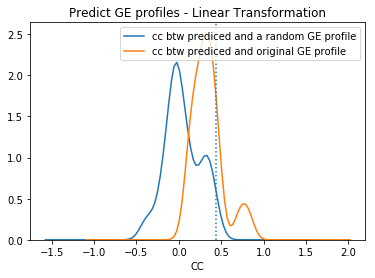

In [55]:
con=[]
nTestAlleles=20;
testAs=l1k.Allele.sample(nTestAlleles,random_state=0).tolist()
# testAs=['KRAS_p.G13D', 'RIT1_p.A77P', 'STK11_WT.c', 'STC2_WT.o',
#        'NFE2L2_WT.o', 'EGFR_p.ELREA746del', 'PIK3CA_p.123_124MP>IA',
#        'RBM10_p.G153C', 'STC2_p.R5W', 'SOX2_WT.o', 'STK11_WT.o',
#        'TPK1_p.T213S', 'PIK3CA_p.H1047R', 'BRAF_p.H574Q', 'STK11_p.H168R',
#        'NR4A2_p.R572G', 'MAP2K1_WT.c', 'RIT1_WT.c', 'TP53_p.E224D',
#        'PPP2R1A_p.W140C']


trainOverfit=0
con=[]


CP_m=cp.copy().reset_index(drop=True);

if 1:
    l1k_m=l1k.copy().reset_index(drop=True);
    sc = sklearn.preprocessing.StandardScaler()
    CP_m.iloc[CP_m.index,1:]=sc.fit_transform(CP_m.iloc[:,1:]);
    l1k_m.iloc[l1k_m.index,1:]=sc.fit_transform(l1k_m.iloc[:,1:]);


if trainOverfit:
    l1k_train=l1k_m.copy();l1k_test=l1k_m.copy()
    cp_train=CP_m.copy();cp_test=CP_m.copy()    
else:
    l1k_train=l1k_m[~l1k_m[pertColName].isin(testAs)].reset_index(drop=True)
    l1k_test=l1k_m[l1k_m[pertColName].isin(testAs)].reset_index(drop=True)

    cp_train=CP_m[~CP_m[pertColName].isin(testAs)].reset_index(drop=True)
    cp_test=CP_m[CP_m[pertColName].isin(testAs)].reset_index(drop=True)



# outdim_size=o;
pred=linearTransform2(l1k_train.iloc[:,1:].values,cp_train.iloc[:,1:].values,l1k_test.iloc[:,1:].values,cp_test.iloc[:,1:].values);
np.random.seed(0)

al1k_test=l1k_test.iloc[:,1:].values
al1k_train=l1k_train.iloc[:,1:].values

ccSame=[]
ccRandom=[]
for i in range(pred.shape[0]):
    ccSame.append(scipy.stats.pearsonr(pred[i,:], al1k_test[i,:])[0])
#     print(pred,al1k_test.shape,cc)
#     print(al1k_train[np.random.choice(np.random.choice(al1k_train.shape[0],1)),:].shape,al1k_test.shape)
    ccRandom.append(scipy.stats.pearsonr(al1k_train[np.random.choice(np.random.choice(al1k_train.shape[0],1))], al1k_test[i,:])[0])

    
    
    
title=['Predict GE profiles - Linear Transformation','GE features - Linear CCA']
fig, axes = plt.subplots()#(1,1,sharey='row', figsize=(12,6))
# sns.kdeplot(x)
i=0
sns.kdeplot(ccRandom, bw=.4, label="cc btw prediced and a random GE profile")
sns.kdeplot(ccSame, bw=.4, label="cc btw prediced and original GE profile");axes.set_xlabel('CC');
perc5=np.percentile(ccSame, 80);axes.axvline(x=perc5,linestyle=':');
axes.legend();axes.set_title(title[i]);

In [59]:
# ccSame
# testAs
# pred
# l1k_train.iloc[:,1:].values
cp_train#.iloc[:,1:].values

,Allele,Cells_AreaShape_Compactness,Cells_AreaShape_FormFactor,Cells_AreaShape_Zernike_2_0,Cells_AreaShape_Zernike_2_2,Cells_AreaShape_Zernike_3_1,Cells_AreaShape_Zernike_4_2,Cells_Correlation_Correlation_DNA_Mito,Cells_Correlation_Correlation_DNA_RNA,Cells_Correlation_Correlation_Mito_ER,...,Nuclei_Texture_SumAverage_RNA_3_0,Nuclei_Texture_SumEntropy_ER_10_0,Nuclei_Texture_SumEntropy_RNA_10_0,Nuclei_Texture_SumVariance_AGP_3_0,Nuclei_Texture_SumVariance_Mito_10_0,Nuclei_Texture_SumVariance_RNA_3_0,Nuclei_Texture_Variance_AGP_10_0,Nuclei_Texture_Variance_ER_10_0,Nuclei_Texture_Variance_ER_5_0,Nuclei_Texture_Variance_Mito_5_0
0,ABCB9_WT.c,-0.191845,1.299430,-0.399373,1.368990,-0.342091,-0.750166,-0.804077,-0.454055,-0.520315,...,0.980431,-0.611550,0.864754,-0.395239,-1.257584,0.868847,-0.077642,-0.382022,-0.425026,-0.967969
1,ABCB9_WT.o,-0.116208,1.210811,-0.508598,1.354200,-0.114931,-0.584200,-0.872543,-1.404232,-1.013573,...,0.899460,-0.928976,0.519104,-1.591608,-1.397032,0.166127,-1.171334,-0.740876,-0.647260,-0.907015
2,ABCB9_p.R281L,-0.035658,1.151647,-0.567224,1.479972,-0.001359,-0.386548,-1.406472,-1.612873,-1.454529,...,0.830401,-1.040483,0.742169,-1.395960,-0.991445,0.277060,-1.259125,-1.173187,-1.135569,-0.889493
3,ABCB9_p.V140M,0.069514,1.316643,-0.821988,2.024729,-0.306436,-0.222774,-1.928465,-2.452597,-1.205377,...,0.628732,-1.090689,0.777265,-1.620900,-1.308102,0.422139,-1.034933,-0.576538,-0.726424,-0.880299
4,ACAA1_WT.o,-0.100920,-0.993268,0.813090,-1.131488,0.120389,0.582971,0.731203,1.030200,1.143261,...,-1.197910,-0.061288,-0.518168,-0.165942,-0.413238,0.150587,0.392322,0.193822,0.017083,-0.515917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,ZNF597_WT.o,-0.148759,-0.931746,0.809964,-1.043620,-0.026819,0.491248,1.168731,1.058406,0.639353,...,-0.121476,0.162986,-0.182918,0.858715,0.005679,-0.352619,0.784060,0.228358,0.333765,0.135036
501,ZNF597_p.F16L,-0.427390,-2.061165,0.422760,-1.283737,0.050852,-0.426001,1.697929,1.501653,0.352160,...,-1.296470,0.465323,-0.640709,1.739560,1.760356,0.277674,1.331900,0.004570,0.340507,1.902309
502,ZNF597_p.L283V,-0.207636,-1.586141,1.112883,-1.439896,-0.449092,0.283276,1.189230,1.146437,1.049055,...,-0.366343,0.414109,-0.372778,1.127548,0.384705,-0.307221,0.819504,0.192288,0.257865,0.064054
503,ZNF597_p.R247T,0.072839,1.170151,-0.749493,1.576424,0.288389,-0.232584,-1.207185,-1.292775,-1.191506,...,0.864372,-0.621617,0.423866,-0.902921,-0.837335,0.297656,-1.055912,-1.065146,-0.712815,-0.571140


In [40]:
# ccRandom

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/marziehhaghighi/rosetta-cp2ge/e4acd1a058e246c892f4f6f0c2f9d2d6
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     sys.gpu.0.free_memory [49]    : (12499615744.0, 12500664320.0)
COMET INFO:     sys.gpu.0.gpu_utilization [49]: (0.0, 0.0)
COMET INFO:     sys.gpu.0.total_memory        : (12796690432.0, 12796690432.0)
COMET INFO:     sys.gpu.0.used_memory [49]    : (296026112.0, 297074688.0)
COMET INFO:     sys.gpu.1.free_memory [49]    : (11488264192.0, 11488264192.0)
COMET INFO:     sys.gpu.1.gpu_utilization [49]: (0.0, 17.0)
COMET INFO:     sys.gpu.1.total_memory        : (12788498432.0, 12788498432.0)
COMET INFO:     sys.gpu.1.used_memory [49]    : (1300234240.0, 1300234240.0)
COMET INFO:     sys.gpu.2.free_memory [49]    : (12567248896.0, 12567248896.0)
COMET INFO:     sys.gpu.2.gpu_utilization [49]: (0.0, 0.0)
COMET INFO:     sys.gpu.2.

Total pairs: 505 (505, 291) (505, 978)
Total pairs: 20 (20, 291) (20, 978)
Epoch 1/300
5/5 [==============================] - 8s 2s/step - loss: 11.0785 - dense_56_loss: 1.0092 - dense_60_loss: 0.9865 - dense_56_mean_absolute_error: 1.0092 - dense_56_pcc: 0.9998 - dense_60_mean_absolute_error: 0.9865 - dense_60_pcc: 0.9978 - val_loss: 8.5578 - val_dense_56_loss: 0.7768 - val_dense_60_loss: 0.7897 - val_dense_56_mean_absolute_error: 0.7768 - val_dense_56_pcc: 0.9984 - val_dense_60_mean_absolute_error: 0.7897 - val_dense_60_pcc: 0.9559
Epoch 2/300
5/5 [==============================] - 0s 31ms/step - loss: 10.5330 - dense_56_loss: 0.9643 - dense_60_loss: 0.8903 - dense_56_mean_absolute_error: 0.9643 - dense_56_pcc: 0.9980 - dense_60_mean_absolute_error: 0.8903 - dense_60_pcc: 0.9705 - val_loss: 8.2963 - val_dense_56_loss: 0.7617 - val_dense_60_loss: 0.6797 - val_dense_56_mean_absolute_error: 0.7617 - val_dense_56_pcc: 0.9860 - val_dense_60_mean_absolute_error: 0.6797 - val_dense_60_pcc: 

Epoch 36/300
5/5 [==============================] - 0s 31ms/step - loss: 7.5498 - dense_56_loss: 0.7012 - dense_60_loss: 0.5379 - dense_56_mean_absolute_error: 0.7012 - dense_56_pcc: 0.8941 - dense_60_mean_absolute_error: 0.5379 - dense_60_pcc: 0.6042 - val_loss: 6.5527 - val_dense_56_loss: 0.6065 - val_dense_60_loss: 0.4874 - val_dense_56_mean_absolute_error: 0.6065 - val_dense_56_pcc: 0.7814 - val_dense_60_mean_absolute_error: 0.4874 - val_dense_60_pcc: 0.5329
Epoch 37/300
5/5 [==============================] - 0s 24ms/step - loss: 7.5601 - dense_56_loss: 0.7011 - dense_60_loss: 0.5486 - dense_56_mean_absolute_error: 0.7011 - dense_56_pcc: 0.8960 - dense_60_mean_absolute_error: 0.5486 - dense_60_pcc: 0.5923 - val_loss: 6.5490 - val_dense_56_loss: 0.6063 - val_dense_60_loss: 0.4860 - val_dense_56_mean_absolute_error: 0.6063 - val_dense_56_pcc: 0.7813 - val_dense_60_mean_absolute_error: 0.4860 - val_dense_60_pcc: 0.5312
Epoch 38/300
5/5 [==============================] - 0s 30ms/step -

Epoch 54/300
5/5 [==============================] - 0s 28ms/step - loss: 7.6473 - dense_56_loss: 0.7049 - dense_60_loss: 0.5985 - dense_56_mean_absolute_error: 0.7049 - dense_56_pcc: 0.8732 - dense_60_mean_absolute_error: 0.5985 - dense_60_pcc: 0.6461 - val_loss: 6.4540 - val_dense_56_loss: 0.5984 - val_dense_60_loss: 0.4700 - val_dense_56_mean_absolute_error: 0.5984 - val_dense_56_pcc: 0.7719 - val_dense_60_mean_absolute_error: 0.4700 - val_dense_60_pcc: 0.5147
Epoch 55/300
5/5 [==============================] - 0s 27ms/step - loss: 7.3928 - dense_56_loss: 0.6837 - dense_60_loss: 0.5557 - dense_56_mean_absolute_error: 0.6837 - dense_56_pcc: 0.8632 - dense_60_mean_absolute_error: 0.5557 - dense_60_pcc: 0.5901 - val_loss: 6.4518 - val_dense_56_loss: 0.5983 - val_dense_60_loss: 0.4685 - val_dense_56_mean_absolute_error: 0.5983 - val_dense_56_pcc: 0.7719 - val_dense_60_mean_absolute_error: 0.4685 - val_dense_60_pcc: 0.5130
Epoch 56/300
5/5 [==============================] - 0s 26ms/step -

Epoch 72/300
5/5 [==============================] - 0s 29ms/step - loss: 7.3703 - dense_56_loss: 0.6821 - dense_60_loss: 0.5490 - dense_56_mean_absolute_error: 0.6821 - dense_56_pcc: 0.8656 - dense_60_mean_absolute_error: 0.5490 - dense_60_pcc: 0.5830 - val_loss: 6.4430 - val_dense_56_loss: 0.5971 - val_dense_60_loss: 0.4717 - val_dense_56_mean_absolute_error: 0.5971 - val_dense_56_pcc: 0.7699 - val_dense_60_mean_absolute_error: 0.4717 - val_dense_60_pcc: 0.5145
Epoch 73/300
5/5 [==============================] - 0s 23ms/step - loss: 7.2731 - dense_56_loss: 0.6732 - dense_60_loss: 0.5411 - dense_56_mean_absolute_error: 0.6732 - dense_56_pcc: 0.8685 - dense_60_mean_absolute_error: 0.5411 - dense_60_pcc: 0.5867 - val_loss: 6.4403 - val_dense_56_loss: 0.5973 - val_dense_60_loss: 0.4677 - val_dense_56_mean_absolute_error: 0.5973 - val_dense_56_pcc: 0.7703 - val_dense_60_mean_absolute_error: 0.4677 - val_dense_60_pcc: 0.5096
Epoch 74/300
5/5 [==============================] - 0s 31ms/step -

Epoch 90/300
5/5 [==============================] - 0s 26ms/step - loss: 7.3706 - dense_56_loss: 0.6841 - dense_60_loss: 0.5291 - dense_56_mean_absolute_error: 0.6841 - dense_56_pcc: 0.8718 - dense_60_mean_absolute_error: 0.5291 - dense_60_pcc: 0.5750 - val_loss: 6.3657 - val_dense_56_loss: 0.5915 - val_dense_60_loss: 0.4511 - val_dense_56_mean_absolute_error: 0.5915 - val_dense_56_pcc: 0.7583 - val_dense_60_mean_absolute_error: 0.4511 - val_dense_60_pcc: 0.4740
Epoch 91/300
5/5 [==============================] - 0s 32ms/step - loss: 7.3453 - dense_56_loss: 0.6801 - dense_60_loss: 0.5445 - dense_56_mean_absolute_error: 0.6801 - dense_56_pcc: 0.8605 - dense_60_mean_absolute_error: 0.5445 - dense_60_pcc: 0.5897 - val_loss: 6.3691 - val_dense_56_loss: 0.5916 - val_dense_60_loss: 0.4531 - val_dense_56_mean_absolute_error: 0.5916 - val_dense_56_pcc: 0.7583 - val_dense_60_mean_absolute_error: 0.4531 - val_dense_60_pcc: 0.4771
Epoch 92/300
5/5 [==============================] - 0s 26ms/step -

Epoch 125/300
5/5 [==============================] - 0s 25ms/step - loss: 7.2892 - dense_56_loss: 0.6754 - dense_60_loss: 0.5351 - dense_56_mean_absolute_error: 0.6754 - dense_56_pcc: 0.8626 - dense_60_mean_absolute_error: 0.5351 - dense_60_pcc: 0.5878 - val_loss: 6.3208 - val_dense_56_loss: 0.5870 - val_dense_60_loss: 0.4510 - val_dense_56_mean_absolute_error: 0.5870 - val_dense_56_pcc: 0.7505 - val_dense_60_mean_absolute_error: 0.4510 - val_dense_60_pcc: 0.4782
Epoch 126/300
5/5 [==============================] - 0s 25ms/step - loss: 7.1915 - dense_56_loss: 0.6675 - dense_60_loss: 0.5166 - dense_56_mean_absolute_error: 0.6675 - dense_56_pcc: 0.8559 - dense_60_mean_absolute_error: 0.5166 - dense_60_pcc: 0.5400 - val_loss: 6.3215 - val_dense_56_loss: 0.5872 - val_dense_60_loss: 0.4496 - val_dense_56_mean_absolute_error: 0.5872 - val_dense_56_pcc: 0.7511 - val_dense_60_mean_absolute_error: 0.4496 - val_dense_60_pcc: 0.4768
Epoch 127/300
5/5 [==============================] - 0s 33ms/ste

Epoch 160/300
5/5 [==============================] - 0s 28ms/step - loss: 6.8923 - dense_56_loss: 0.6400 - dense_60_loss: 0.4922 - dense_56_mean_absolute_error: 0.6400 - dense_56_pcc: 0.8486 - dense_60_mean_absolute_error: 0.4922 - dense_60_pcc: 0.5216 - val_loss: 6.2575 - val_dense_56_loss: 0.5815 - val_dense_60_loss: 0.4424 - val_dense_56_mean_absolute_error: 0.5815 - val_dense_56_pcc: 0.7408 - val_dense_60_mean_absolute_error: 0.4424 - val_dense_60_pcc: 0.4570
Epoch 161/300
5/5 [==============================] - 0s 28ms/step - loss: 6.8252 - dense_56_loss: 0.6317 - dense_60_loss: 0.5082 - dense_56_mean_absolute_error: 0.6317 - dense_56_pcc: 0.8256 - dense_60_mean_absolute_error: 0.5082 - dense_60_pcc: 0.5298 - val_loss: 6.2541 - val_dense_56_loss: 0.5810 - val_dense_60_loss: 0.4436 - val_dense_56_mean_absolute_error: 0.5810 - val_dense_56_pcc: 0.7397 - val_dense_60_mean_absolute_error: 0.4436 - val_dense_60_pcc: 0.4558
Epoch 162/300
5/5 [==============================] - 0s 30ms/ste

Epoch 195/300
5/5 [==============================] - 0s 30ms/step - loss: 7.0596 - dense_56_loss: 0.6514 - dense_60_loss: 0.5458 - dense_56_mean_absolute_error: 0.6514 - dense_56_pcc: 0.8310 - dense_60_mean_absolute_error: 0.5458 - dense_60_pcc: 0.5934 - val_loss: 6.2064 - val_dense_56_loss: 0.5766 - val_dense_60_loss: 0.4403 - val_dense_56_mean_absolute_error: 0.5766 - val_dense_56_pcc: 0.7301 - val_dense_60_mean_absolute_error: 0.4403 - val_dense_60_pcc: 0.4474
Epoch 196/300
5/5 [==============================] - 0s 41ms/step - loss: 7.0014 - dense_56_loss: 0.6515 - dense_60_loss: 0.4866 - dense_56_mean_absolute_error: 0.6515 - dense_56_pcc: 0.8171 - dense_60_mean_absolute_error: 0.4866 - dense_60_pcc: 0.4993 - val_loss: 6.2047 - val_dense_56_loss: 0.5763 - val_dense_60_loss: 0.4413 - val_dense_56_mean_absolute_error: 0.5763 - val_dense_56_pcc: 0.7304 - val_dense_60_mean_absolute_error: 0.4413 - val_dense_60_pcc: 0.4491
Epoch 197/300
5/5 [==============================] - 0s 33ms/ste

Epoch 230/300
5/5 [==============================] - 0s 29ms/step - loss: 6.7930 - dense_56_loss: 0.6312 - dense_60_loss: 0.4807 - dense_56_mean_absolute_error: 0.6312 - dense_56_pcc: 0.8127 - dense_60_mean_absolute_error: 0.4807 - dense_60_pcc: 0.5018 - val_loss: 6.1559 - val_dense_56_loss: 0.5708 - val_dense_60_loss: 0.4476 - val_dense_56_mean_absolute_error: 0.5708 - val_dense_56_pcc: 0.7204 - val_dense_60_mean_absolute_error: 0.4476 - val_dense_60_pcc: 0.4578
Epoch 231/300
5/5 [==============================] - 0s 29ms/step - loss: 6.9765 - dense_56_loss: 0.6479 - dense_60_loss: 0.4975 - dense_56_mean_absolute_error: 0.6479 - dense_56_pcc: 0.8481 - dense_60_mean_absolute_error: 0.4975 - dense_60_pcc: 0.5348 - val_loss: 6.1599 - val_dense_56_loss: 0.5714 - val_dense_60_loss: 0.4459 - val_dense_56_mean_absolute_error: 0.5714 - val_dense_56_pcc: 0.7214 - val_dense_60_mean_absolute_error: 0.4459 - val_dense_60_pcc: 0.4566
Epoch 232/300
5/5 [==============================] - 0s 26ms/ste

Epoch 265/300
5/5 [==============================] - 0s 40ms/step - loss: 6.5114 - dense_56_loss: 0.6044 - dense_60_loss: 0.4670 - dense_56_mean_absolute_error: 0.6044 - dense_56_pcc: 0.7945 - dense_60_mean_absolute_error: 0.4670 - dense_60_pcc: 0.5098 - val_loss: 6.0876 - val_dense_56_loss: 0.5650 - val_dense_60_loss: 0.4378 - val_dense_56_mean_absolute_error: 0.5650 - val_dense_56_pcc: 0.7073 - val_dense_60_mean_absolute_error: 0.4378 - val_dense_60_pcc: 0.4400
Epoch 266/300
5/5 [==============================] - 0s 27ms/step - loss: 6.7716 - dense_56_loss: 0.6270 - dense_60_loss: 0.5012 - dense_56_mean_absolute_error: 0.6270 - dense_56_pcc: 0.7968 - dense_60_mean_absolute_error: 0.5012 - dense_60_pcc: 0.5550 - val_loss: 6.0855 - val_dense_56_loss: 0.5648 - val_dense_60_loss: 0.4370 - val_dense_56_mean_absolute_error: 0.5648 - val_dense_56_pcc: 0.7071 - val_dense_60_mean_absolute_error: 0.4370 - val_dense_60_pcc: 0.4384
Epoch 267/300
5/5 [==============================] - 0s 25ms/ste

Epoch 300/300
5/5 [==============================] - 0s 30ms/step - loss: 6.9110 - dense_56_loss: 0.6376 - dense_60_loss: 0.5352 - dense_56_mean_absolute_error: 0.6376 - dense_56_pcc: 0.7690 - dense_60_mean_absolute_error: 0.5352 - dense_60_pcc: 0.5695 - val_loss: 6.0742 - val_dense_56_loss: 0.5639 - val_dense_60_loss: 0.4351 - val_dense_56_mean_absolute_error: 0.5639 - val_dense_56_pcc: 0.7066 - val_dense_60_mean_absolute_error: 0.4351 - val_dense_60_pcc: 0.4283


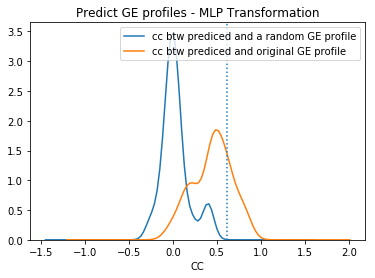

In [80]:
# prednn=nnTransform(l1k_train,cp_train,l1k_test,cp_test)
prednn=nnTransformWithCycle(l1k_train,cp_train,l1k_test,cp_test)
# pred=linearTransform2(l1k_train.iloc[:,1:].values,cp_train.iloc[:,1:].values,l1k_test.iloc[:,1:].values,cp_test.iloc[:,1:].values);


al1k_test=l1k_test.iloc[:,1:].values
al1k_train=l1k_train.iloc[:,1:].values

ccSame=[]
ccRandom=[]
for i in range(prednn.shape[0]):
    ccSame.append(scipy.stats.pearsonr(prednn[i,:], al1k_test[i,:])[0])
#     print(pred,al1k_test.shape,cc)
#     print(al1k_train[np.random.choice(np.random.choice(al1k_train.shape[0],1)),:].shape,al1k_test.shape)
    ccRandom.append(scipy.stats.pearsonr(al1k_train[np.random.choice(np.random.choice(al1k_train.shape[0],1))], al1k_test[i,:])[0])

    
    
    
title=['Predict GE profiles - MLP Transformation','GE features - Linear CCA']
fig, axes = plt.subplots()#(1,1,sharey='row', figsize=(12,6))
# sns.kdeplot(x)
i=0
sns.kdeplot(ccRandom, bw=.4, label="cc btw prediced and a random GE profile")
sns.kdeplot(ccSame, bw=.4, label="cc btw prediced and original GE profile");axes.set_xlabel('CC');
perc5=np.percentile(ccSame, 80);axes.axvline(x=perc5,linestyle=':');
axes.legend();axes.set_title(title[i]);

In [19]:
from numpy.linalg import inv
# Find the mapping between CP and L1k
def linearTransform2(al1k_train,acp_train,al1k_test,acp_test):
#     acp_train=np.concatenate((acp_train,np.ones((acp_train.shape[0],1))),axis=1);
# #     print(acp_test.shape)
#     acp_test=np.concatenate((acp_test,np.ones((acp_test.shape[0],1))),axis=1);
#     print(acp_test.shape)
    A=np.matmul(np.matmul(inv(np.matmul(np.transpose(acp_train),acp_train)),np.transpose(acp_train)),al1k_train)
    pred=np.matmul(acp_test,A)
#     print(pred[0].shape,al1k_test[0].shape)
#     print(np.random.choice(np.random.choice(al1k_train.shape[0],1)))
    return pred

In [38]:
# prednn

In [39]:
# prednn[0]

In [ ]:
195.84/24

In [ ]:
Resss=pd.read_csv('../../results/results-Treatment.csv')

Resss.mean()

In [ ]:
Res

In [ ]:
Res.mean()

In [ ]:
Res

In [ ]:
Res

In [ ]:
l1k_m.Allele.tolist()

In [ ]:
Res.mean()

In [ ]:
ls

In [ ]:
Res2=Res.iloc[173:,:]
Res2.to_csv('results.csv' , index=False)

In [ ]:
l1k_m['Allele'].isin(a_train)